In [1]:
import argparse
from mpi4py import MPI
import numpy as np
import h5py
import seaborn as sb
import matplotlib.pyplot as plt
from numpy.fft import irfft, rfft
from scipy.interpolate import RectBivariateSpline
from glob import glob
import emcee
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import keras_tuner as kt
# from lyanna_utils import * 
from chainconsumer import ChainConsumer
from lyanna.lyanna_utils import *
from lyanna.datautils import *
from lyanna.losses import *
#from livelossplot import PlotLossesKeras

In [2]:
plt.rcParams['font.size']       = 19
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['text.usetex']     = True
plt.rcParams['axes.facecolor']  = 'w'

In [3]:
N_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
GPU_id = 1
# dist_strategy   = tf.distribute.MirroredStrategy()
print(f"Using TensorFlow with {N_gpus} GPUs")

Using TensorFlow with 2 GPUs


In [4]:
op_path    = 'ensemble_kt_rSansa_Ext2/'
data_path  = '/project/ls-gruen/users/parth.nayak/lyanna_data/'+op_path
if not os.path.exists(op_path):
    os.mkdir(op_path)
if not os.path.exists(data_path):
    os.mkdir(data_path)

## Getting the input data

In [5]:
filespath  = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/orthogonal_grid_models/'
Oracle     = FilesOracle(filespath)
T0s_orthogrid    = Oracle.T0s
gammas_orthogrid = Oracle.gammas
alphas     = Oracle.alphas
betas      = Oracle.betas
hfiles     = Oracle.hfiles

extpath    = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/ortho_extended_grid_models/'
Oracle_ext = FilesOracle(extpath)
T0s_extorthogrid    = Oracle_ext.T0s
gammas_extorthogrid = Oracle_ext.gammas
alphas_ext = Oracle_ext.alphas
betas_ext  = Oracle_ext.betas
hfiles_ext = Oracle_ext.hfiles

filespath_offgrid  = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/rescaled_tdr_models/off_grid_models/range_2/'
Oracle_offgrid     = FilesOracle(filespath_offgrid)
hfiles_offgrid     = Oracle_offgrid.hfiles
T0s_offgrid        = Oracle_offgrid.T0s
gammas_offgrid     = Oracle_offgrid.gammas
alphas_offgrid     = Oracle_offgrid.alphas
betas_offgrid      = Oracle_offgrid.betas

k          = Oracle.k
k_full     = Oracle.k_full
v_h_skewer = Oracle.v_h_skewer_full
N_pixels   = Oracle.N_pixels_full
delta_v    = Oracle.delta_v_full

In [6]:
T0s_orthogrid_upscaled    = rescale_T0(T0s_orthogrid, mode = 'up')
gammas_orthogrid_upscaled = rescale_gamma(gammas_orthogrid, mode = 'up')

T0s_extorthogrid_upscaled    = rescale_T0(T0s_extorthogrid, mode = 'up')
gammas_extorthogrid_upscaled = rescale_gamma(gammas_extorthogrid, mode = 'up')

T0s_offgrid_upscaled    = rescale_T0(T0s_offgrid, mode = 'up')
gammas_offgrid_upscaled = rescale_gamma(gammas_offgrid, mode = 'up')

In [7]:
N_extrows_beta  = 2

if N_extrows_beta == 0:
    extension = False
elif N_extrows_beta>0:
    extension = True

In [8]:
indices_to_pick  = []
for indstart in range(3-N_extrows_beta, 3+N_extrows_beta):
    indices_to_pick.append(np.arange(indstart, indstart+len(T0s_extorthogrid), 3*2))
indices_to_pick  = np.array(indices_to_pick)
indices_to_pick  = np.ravel(indices_to_pick)
indices_to_pick  = np.sort(indices_to_pick)

In [9]:
N_skewers_each_train = 24000
N_skewers_each_valid = 8000
N_skewers_each_test  = 4000

data = get_data_for_sansa(
    training = False, validation = True, test = True, extension = False, smooth = True,
    N_sk_each_train = N_skewers_each_train,
    N_sk_each_valid = N_skewers_each_valid,
    N_sk_each_test  = N_skewers_each_test,
)

# train_spectra = data['training']
valid_spectra = data['validation']
test_spectra  = data['test']

In [10]:
test_spectra.shape, valid_spectra.shape

((484000, 517, 1), (968000, 517, 1))

In [11]:
fidfilename = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/fiducial_tdr_models/extracted_lya_abs_profiles_redshift_2.2_grid1_01722_S5678_cutoff_doppler.h5'
fid_test_spectra = sansa_test_data_inference(fidfilename, N_sk_to_pick = 2*N_skewers_each_test, smooth = True)
fid_test_spectra.shape

(8000, 517, 1)

In [12]:
T0_fid, gamma_fid  = fid_test_spectra[0, 512:514, 0]
T0_fid_upscaled    = rescale_T0(T0_fid, mode = 'up')
gamma_fid_upscaled = rescale_gamma(gamma_fid, mode = 'up') 

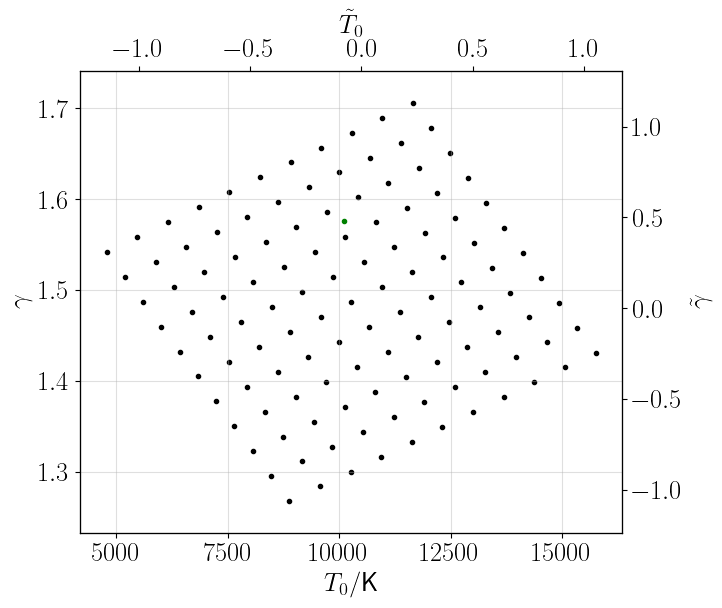

In [13]:
fig, ax = plt.subplots(figsize=(7,6))
# axs = fig.subplots(1, 2) 
ax.scatter(T0s_orthogrid_upscaled, gammas_orthogrid_upscaled, color = 'k', s = 9)
ax.scatter(rescale_T0(fid_test_spectra[0,512,0], mode = 'up'), rescale_gamma(fid_test_spectra[0,513,0], mode = 'up'), color = 'g', s = 9)
x_lims = [T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600]
y_lims = [gammas_orthogrid_upscaled.min()-0.035, gammas_orthogrid_upscaled.max()+0.035]
# plt.scatter(alphas, betas, color = 'k', s = 9)
# [axs[i].grid(alpha = 0.4) for i in range(2)]
ax.grid(alpha = 0.4)
ax.set_xlabel(r'$T_0$/K')
ax.set_ylabel(r'$\gamma$')
ax.set_xlim(*x_lims)
ax.set_ylim(*y_lims);

ax_y = ax.twinx()
ax_y.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_y.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_y.set_ylabel(r'$\tilde{\gamma}$')

ax_x = ax.twiny()
ax_x.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_x.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
ax_x.set_xlabel(r'$\tilde{T}_0$');

# plt.savefig('orthogrid_space_twin_xy.pdf', bbox_inches = 'tight')
# axs[1].set_xlabel(r'$\alpha$')
# axs[1].set_ylabel(r'$\beta$')
# plt.subplots_adjust(wspace = 0.25);

In [14]:
T0s_arr_prior    = rescale_T0(np.linspace(T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600, 500))
gammas_arr_prior = rescale_gamma(np.linspace(gammas_orthogrid_upscaled.min()-0.025, gammas_orthogrid_upscaled.max()+0.025, 500))

T0s_prior, gammas_prior = np.meshgrid(T0s_arr_prior, gammas_arr_prior)

Prior_matrix = []
for T0 in T0s_arr_prior:
    tmp = []
    for gamma in gammas_arr_prior:
        tmp.append(Oracle.in_prior_volume(T0, gamma))
    Prior_matrix.append(tmp)
Prior_matrix = np.array(Prior_matrix).T
Prior_matrix.shape

(500, 500)

In [15]:
T0s_prior_upscaled    = rescale_T0(T0s_prior, mode = 'up')
gammas_prior_upscaled = rescale_gamma(gammas_prior, mode = 'up')

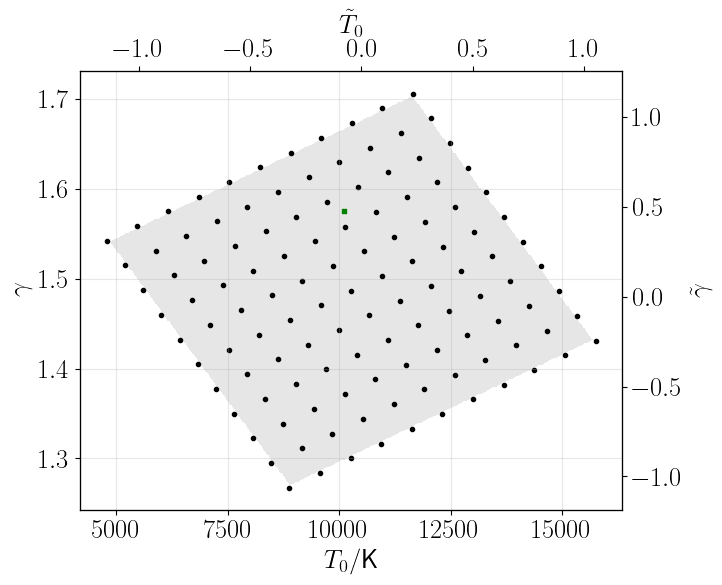

In [16]:
fig, ax = plt.subplots(figsize=(7,5.7))
# axs = fig.subplots(1, 2) 
ax.pcolormesh(T0s_prior_upscaled, gammas_prior_upscaled, Prior_matrix, cmap = 'binary', shading = 'auto', vmin = 0., vmax = 10.)
ax.scatter(T0s_orthogrid_upscaled, gammas_orthogrid_upscaled, color = 'k', s = 9, label = 'original',)
ax.scatter(T0_fid_upscaled, gamma_fid_upscaled, color = 'g', s = 9, marker = 's')
# ax.scatter(T0s_extorthogrid_upscaled[indices_to_pick], gammas_extorthogrid_upscaled[indices_to_pick], color = 'g', s = 20, label = 'extended', marker = 'x')
# x_lims = [T0s_extorthogrid_upscaled.min()-600, T0s_extorthogrid_upscaled.max()+600]
# y_lims = [gammas_extorthogrid_upscaled.min()-0.025, gammas_extorthogrid_upscaled.max()+0.025]

x_lims = [T0s_orthogrid_upscaled.min()-600, T0s_orthogrid_upscaled.max()+600]
y_lims = [gammas_orthogrid_upscaled.min()-0.025, gammas_orthogrid_upscaled.max()+0.025]

# plt.scatter(alphas, betas, color = 'k', s = 9)
# [axs[i].grid(alpha = 0.4) for i in range(2)]
# ax.legend(loc = 'upper right')
ax.grid(alpha = 0.3)
ax.set_xlabel(r'$T_0$/K')
ax.set_ylabel(r'$\gamma$')
ax.set_xlim(*x_lims)
ax.set_ylim(*y_lims);

ax_y = ax.twinx()
# ax_y.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
# ax_y.scatter(T0s_extorthogrid[indices_to_pick], gammas_extorthogrid[indices_to_pick], color = 'g', s = 9,)
# ax_y.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
ax_y.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_y.set_ylabel(r'$\tilde{\gamma}$')

ax_x = ax.twiny()
# ax_x.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
# ax_x.scatter(T0s_extorthogrid[indices_to_pick], gammas_extorthogrid[indices_to_pick], color = 'g', s = 9,)

ax_x.set_xlim(rescale_T0(x_lims[0]), rescale_T0(x_lims[1]))
# ax_x.set_ylim(rescale_gamma(y_lims[0]), rescale_gamma(y_lims[1]))
ax_x.set_xlabel(r'$\tilde{T}_0$');

# plt.savefig('orthogrid_space_twin_xy_with_shaded_prior_&_fiducial_tdr.pdf', bbox_inches = 'tight', dpi = 400)
# axs[1].set_xlabel(r'$\alpha$')
# axs[1].set_ylabel(r'$\beta$')
# plt.subplots_adjust(wspace = 0.25);

## Setting up Sansa

In [17]:
kt_impl_id = 2 # kt is keras-tuner 

In [18]:
class ResBlock:
    # impl_id 0-
    def __init__(self, num_filters, kernel_size, strides = 2, activation = None, padding = 'same', regularizer = None, initializer = None, dropout = 0.0, idx = 0):
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides     = strides 
        self.activation  = activation
        self.padding     = padding
        self.regularizer = regularizer
        self.initializer = initializer
        self.dropout     = dropout
        self.idx         = idx 
        self.num_clayers = 3
        
    def __call__(self, x):
        x = tf.keras.layers.Conv1D(self.num_filters, self.kernel_size, strides = self.strides, activation = None, padding = self.padding, kernel_regularizer = self.regularizer, kernel_initializer = self.initializer, name = f'conv_{self.num_clayers*self.idx}')(x)
        x_skip = x
        x = tf.keras.layers.Conv1D(self.num_filters, self.kernel_size, strides = 1, activation = self.activation, padding = self.padding, kernel_regularizer = self.regularizer, kernel_initializer = self.initializer, name = f'conv_{self.num_clayers*self.idx+1}')(x)
        x = tf.keras.layers.Conv1D(self.num_filters, self.kernel_size, strides = 1, activation = None, padding = self.padding, kernel_regularizer = self.regularizer, kernel_initializer = self.initializer, name = f'conv_{self.num_clayers*self.idx+2}')(x)
        x = tf.keras.layers.Add(name = f'skip_{self.idx}')([x_skip, x])
        x = tf.keras.layers.LeakyReLU()(x)
        return x

In [19]:
def create_Sansa(hp):
    ### impl_id 0 
    conv_dropout_rate  = hp.Float("conv_dropout_rate", min_value = 0.0, max_value = 0.15, step = 0.01)
    # dense_dropout_rate = hp.Float("dense_dropout_rate", min_value = 0.0, max_value = 0.15, step = 0.01)
    l2_conv            = hp.Float("l2_conv", min_value = 1e-9, max_value = 1e-5, sampling = 'log', default = 1e-7) # , step = 10**0.5
    l2_dense           = hp.Float("l2_dense", min_value = 1e-9, max_value = 1e-5, sampling = 'log', default = 1e-7)

    conv_regularizer   = tf.keras.regularizers.L2(l2=l2_conv)
    dense_regularizer  = tf.keras.regularizers.L2(l2=l2_dense)

    conv_initializer   = tf.keras.initializers.GlorotNormal(seed = 0)
    dense_initializer  = tf.keras.initializers.HeNormal(seed = 0)
    
    tf.random.set_seed(15)

    ## Below is the Functional API of the model 
    inputs = tf.keras.layers.Input(shape = (512,1))
    
    # First Residual Block
    x = ResBlock(16, 16, strides = 2, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 0)(inputs)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_0')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_0')(x)
    x = tf.keras.layers.AveragePooling1D(4, padding = 'same', name = 'avgpool_0')(x)
    
    # Second Residual Block
    x = ResBlock(32, 8, strides = 2, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 1)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_1')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_1')(x)
    x = tf.keras.layers.AveragePooling1D(4, padding = 'same', name = 'avgpool_1')(x)
    
    # Third Residual Block
    x = ResBlock(32, 8, strides = 1, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 2)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_2')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_2')(x)
    x = tf.keras.layers.AveragePooling1D(2, padding = 'same', name = 'avgpool_2')(x)

    # Fourth Residual Block
    x = ResBlock(64, 8, strides = 1, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 3)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_3')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_3')(x)
    x = tf.keras.layers.AveragePooling1D(2, padding = 'same', name = 'avgpool_3')(x)
    
    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    
    # x = tf.keras.layers.Dense(64, activation = 'sigmoid', kernel_regularizer = dense_regularizer, kernel_initializer = dense_initializer, bias_initializer = dense_initializer, name = 'dense_1')(x)
    # x = tf.keras.layers.BatchNormalization(name = 'batch_norm_3')(x)
    # x = tf.keras.layers.Dropout(dense_dropout_rate, name = 'dropout_dense_1')(x)
    output = tf.keras.layers.Dense(5, activation = None, use_bias = False, kernel_regularizer = dense_regularizer, kernel_initializer = dense_initializer, name = 'dense_final')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = output, name = 'rSansa') 
    ## Model building API ends 

    # model.summary()

    init_lr       = 2e-5 #hp.Float("init_lr", min_value = 1e-6, max_value = 1e-3, sampling = 'reverse_log', default = 1e-5) # , step = 10**0.25
    beta_1        = hp.Float("beta_1", min_value = 0.8, max_value = 0.99, step = 0.01, default = 0.9)
    beta_2        = 0.999 #hp.Float("beta_2", min_value = 0.9985, max_value = 0.9995, step = 0.0001, default = 0.999)

    lr_schedule_epoch  = 10 #hp.Int("lr_schedule_epoch", min_value = 40, max_value = 60, step = 5)
    #final_lr      = hp.Float("final_lr", min_value = init_lr * 0.10, max_value = init_lr * 0.75, step = init_lr*0.05)
    lr_decay_rate = 0.975 #hp.Float("lr_decay_rate", min_value = 0.96, max_value = 1.00, step = 0.005)
    
    lr_schedule   = tf.keras.optimizers.schedules.ExponentialDecay(
        init_lr, 
        N_steps_per_epoch*lr_schedule_epoch, 
        lr_decay_rate, 
        staircase = True,
    )

    optimizer     = tf.keras.optimizers.Adam(
        learning_rate = lr_schedule,
        beta_1        = beta_1,
        beta_2        = beta_2,
    )

    loss_fn = NL3_2P_positive()
    
    model.compile(
        optimizer = optimizer, 
        loss      = loss_fn,
        metrics   = [loss_fn.ChiSquaredError, loss_fn.MeanSquaredError, loss_fn.LogDeterminantSigma],
    )
    
    return model

In [20]:
N_epoch    = 1500 #2000
# batch_size = 16500 * N_gpus #14520 
N_steps_per_epoch = 100
batch_size        = N_skewers_each_train*(len(alphas)+len(alphas_ext[indices_to_pick]))//N_steps_per_epoch

tuner = kt.BayesianOptimization(
    hypermodel = create_Sansa,
    objective  = kt.Objective('val_loss', direction = 'min'),
    # beta       = 3.0,
    # max_trials = 400, #800
    # seed       = impl_id * 400 + GPU_id, #800 
    # executions_per_trial = 1,
    # distribution_strategy = dist_strategy, #tf.distribute.MirroredStrategy(),
    overwrite  = False,
    directory  = f'kt_rSansa_Ext2/tuner_impl_{kt_impl_id}',
    project_name = 'trials',
)

Reloading Tuner from kt_rSansa_Ext2/tuner_impl_2/trials/tuner0.json


KeyError: 'message'

In [19]:
def create_rSansa():
    
    conv_dropout_rate  = 0.14
    
    l2_conv  = 2.0732014674545065e-07 
    l2_dense = 3.642709112553934e-08
    
    conv_regularizer   = tf.keras.regularizers.L2(l2 = l2_conv)
    dense_regularizer  = tf.keras.regularizers.L2(l2 = l2_dense)
    
    conv_initializer   = tf.keras.initializers.GlorotNormal(seed = 0)
    dense_initializer  = tf.keras.initializers.HeNormal(seed = 0)
    
    tf.random.set_seed(15)
    # model = tf.keras.Sequential()
    
    inputs = tf.keras.layers.Input(shape = (512,1))
    
    # First Residual Block
    x = ResBlock(16, 16, strides = 2, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 0)(inputs)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_0')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_0')(x)
    x = tf.keras.layers.AveragePooling1D(4, padding = 'same', name = 'avgpool_0')(x)
    
    # Second Residual Block
    x = ResBlock(32, 8, strides = 2, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 1)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_1')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_1')(x)
    x = tf.keras.layers.AveragePooling1D(4, padding = 'same', name = 'avgpool_1')(x)

    # Third Residual Block
    x = ResBlock(32, 8, strides = 1, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 2)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_2')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_2')(x)
    x = tf.keras.layers.AveragePooling1D(2, padding = 'same', name = 'avgpool_2')(x)

    # Fourth Residual Block
    x = ResBlock(64, 8, strides = 1, activation = 'leaky_relu', padding = 'same', regularizer = conv_regularizer, initializer = conv_initializer, dropout = conv_dropout_rate, idx = 3)(x)
    x = tf.keras.layers.BatchNormalization(name = 'batch_norm_3')(x)
    x = tf.keras.layers.Dropout(conv_dropout_rate, name = 'dropout_conv_3')(x)
    x = tf.keras.layers.AveragePooling1D(2, padding = 'same', name = 'avgpool_3')(x)
    
    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    
    output = tf.keras.layers.Dense(5, activation = None, use_bias = False, kernel_regularizer = dense_regularizer, kernel_initializer = dense_initializer, name = 'dense_final')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = output, name = 'rSansa')
    ## Model building API ends 
    
    return model

In [19]:
best_trials = tuner.oracle.get_best_trials(num_trials = 2)

best_idx           = 1  # '0' = best, '1' = second-best, and so on
trial_under_review = best_trials[best_idx]
best_hp            = trial_under_review.hyperparameters

print('\n############\n') 
print(f"Best hyperparameters from trial {trial_under_review.trial_id}:")
print(best_hp.values, '\n############\n')


############

Best hyperparameters from trial 046:
{'conv_dropout_rate': 0.14, 'l2_conv': 2.0732014674545065e-07, 'l2_dense': 3.642709112553934e-08, 'beta_1': 0.9900000000000002} 
############



In [20]:
tf.keras.backend.clear_session()
with tf.device(f'/device:GPU:{GPU_id}'):
# with dist_strategy.scope():
    # rsansa = tuner.get_best_models(num_models = 1)[0]
    # rsansa  = tuner.hypermodel.build(best_hp)
    rsansa = create_rSansa()
rsansa.summary()

Model: "rSansa"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 conv_0 (Conv1D)                (None, 256, 16)      272         ['input_1[0][0]']                
                                                                                                  
 conv_1 (Conv1D)                (None, 256, 16)      4112        ['conv_0[0][0]']                 
                                                                                                  
 conv_2 (Conv1D)                (None, 256, 16)      4112        ['conv_1[0][0]']                 
                                                                                             

In [21]:
weights_path = data_path+f'retraining_tuner_impl_{kt_impl_id}/'

In [22]:
N_members_committee = 10
best_network_idx = 7
best_epochs  = np.array([962,936,743,635,578,1345,650,1139,849,1062])+1
indsort_nets = np.array([7, 3, 5, 2, 8, 9, 6, 4, 0, 1]) 

In [23]:
Ws_rsansa = np.load(op_path+f'retraining_tuner_impl_{kt_impl_id}/rsansa_committee_W_matrices_retrained_kt{kt_impl_id}_{N_members_committee}runs.npy')
Ds_rsansa = np.load(op_path+f'retraining_tuner_impl_{kt_impl_id}/rsansa_committee_D_vectors_retrained_kt{kt_impl_id}_{N_members_committee}runs.npy');

In [28]:
# Ws_rsansa[0], np.linalg.inv(Ws_rsansa[0])

## Predicting with Sansa

In [24]:
rsansa_committee_predictions      = []
test_rsansa_committee_predictions = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    with tf.device(f'/device:GPU:{GPU_id}'):
        rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
        rsansa_committee_predictions.append(rsansa.predict(valid_spectra[:, :512, :]))
        test_rsansa_committee_predictions.append(rsansa.predict(test_spectra[:, :512, :]))
rsansa_committee_predictions      = np.array(rsansa_committee_predictions)
test_rsansa_committee_predictions = np.array(test_rsansa_committee_predictions)

15125/15125 [==============================] - 28s 2ms/step


In [25]:
rsansa_committee_predictions.shape, test_rsansa_committee_predictions.shape

((10, 968000, 5), (10, 484000, 5))

In [23]:
metrics_valid = rsansa.evaluate(valid_spectra[:, :512, :], valid_spectra[:, 512:, 0])

39250/39250 [==============================] - 125s 3ms/step - loss: -3.3084 - ChiSquaredError: 2.2784 - MeanSquaredError: 0.2548 - LogDeterminantSigma: -5.5869


In [24]:
metrics_test = rsansa.evaluate(test_spectra[:, :512, :], test_spectra[:, 512:, 0])

19625/19625 [==============================] - 62s 3ms/step - loss: -3.3187 - ChiSquaredError: 2.2672 - MeanSquaredError: 0.2539 - LogDeterminantSigma: -5.5860


In [25]:
metrics_fid_test = rsansa.evaluate(fid_test_spectra[:, :512, :], fid_test_spectra[:, 512:, 0])

125/125 [==============================] - 0s 3ms/step - loss: -3.9295 - ChiSquaredError: 1.5271 - MeanSquaredError: 0.1599 - LogDeterminantSigma: -5.4566


In [26]:
rsansa_committee_covariance_matrices = np.zeros((N_members_committee, 2,2))
rsansa_committee_covariance_determinants = []
for i in range(N_members_committee):
    cov = np.cov(rsansa_committee_predictions[i, :, :2], rowvar = False)
    rsansa_committee_covariance_matrices[i] = cov
    rsansa_committee_covariance_determinants.append(np.linalg.det(cov))
rsansa_committee_covariance_determinants = np.array(rsansa_committee_covariance_determinants)
rsansa_committee_covariance_matrices.shape, rsansa_committee_covariance_determinants.shape

((10, 2, 2), (10,))

In [27]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
committee_transformed_network_covariance_matrices = np.zeros((N_members_committee,2,2))
committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(rsansa_committee_predictions[i, :, 2])
    c2s = np.exp(rsansa_committee_predictions[i, :, 3])
    c3s = rsansa_committee_predictions[i, :, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
committee_transformed_network_covariance_matrices.shape, committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [28]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
test_committee_transformed_network_covariance_matrices = np.zeros((N_members_committee,2,2))
test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(test_rsansa_committee_predictions[i, :, 2])
    c2s = np.exp(test_rsansa_committee_predictions[i, :, 3])
    c3s = test_rsansa_committee_predictions[i, :, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
test_committee_transformed_network_covariance_matrices.shape, test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

## Orthogonal basis analysis

In [30]:
range_idx   = 55
true_betas = [] #, []
for idx in range(range_idx, range_idx+11):
    sl   = np.s_[idx*N_skewers_each_test : (idx+1)*N_skewers_each_test]
    true = test_spectra[sl, 512:514, 0]
    true_alpha, true_beta = change_basis(true[:, 0], true[:, 1])
    # true_alphas.append(true_alpha)
    true_betas.append(true_beta)
# true_alphas = np.ravel(np.array(true_alphas))
true_betas  = np.ravel(np.array(true_betas))

Betas      = [] #, []
Mean_betas = [] #, []
Sig_betas  = [] #, []
Min_betas, Max_betas = [], []
#for i, idx in enumerate(range(best_network_idx, best_network_idx+1)): #(N_members_committee):
for i in range(N_members_committee):
    betas      = [] #, []
    means_beta = [] #, []
    sigs_beta  = [] #, []
    mins_beta, maxs_beta = [], []
    for idx in range(range_idx, range_idx+11):
        sl   = np.s_[idx*N_skewers_each_valid : (idx+1)*N_skewers_each_valid]
        # true      = test_spectra[sl, 512:514, 0] #[T0s_orthogrid[idx], gammas_orthogrid[idx]]
        pred_alpha, pred_beta = change_basis(rsansa_committee_predictions[i, sl, 0], rsansa_committee_predictions[i, sl, 1])
        # plt.figure() 
        # plt.hist(pred_beta, bins = 100)#'auto')
        hist,bins=np.histogram(pred_beta,bins=100)#'auto')
        bins=bins[:-1]
        bins+=np.diff(bins)[0]/2
        cumulative_ind=np.argsort(hist)
        cumulative_y=np.cumsum(hist[cumulative_ind])/np.sum(hist)
        select=cumulative_y>=0.317
        min_conf,max_conf=bins[cumulative_ind][select].min(),bins[cumulative_ind][select].max()

        # alphas.append(pred_alpha)
        betas.append(pred_beta)
        # mean_alpha = np.mean(pred_alpha)
        mean_beta  = np.mean(pred_beta)
        # sig_alpha  = np.std(pred_alpha)
        sig_beta   = np.std(pred_beta)
        
        # plt.axvline(true_beta[0], color = 'k')
        # plt.axvline(mean_beta, color = 'g')
        # plt.fill_betweenx([0,300], mean_beta-sig_beta, mean_beta+sig_beta,alpha=0.5,color='r',zorder=5)
        # plt.fill_betweenx([0,hist[cumulative_ind[select]].min()], min_conf, max_conf,alpha=0.5,color='g',zorder=5)
        
        # means_alpha.append(mean_alpha)
        means_beta.append(mean_beta)
        # sigs_alpha.append(sig_alpha)
        sigs_beta.append(sig_beta)
        mins_beta.append(min_conf)
        maxs_beta.append(max_conf)
    # Alphas.append(alphas); 
    Betas.append(betas)
    # Mean_alphas.append(means_alpha); 
    Mean_betas.append(means_beta)
    Min_betas.append(mins_beta); Max_betas.append(maxs_beta)
    # Sig_alphas.append(sigs_alpha); 
    Sig_betas.append(sigs_beta)
    
# Alphas = np.array(Alphas).reshape(len(rsansa_preds), -1) #np.ravel(np.array(alphas))
Betas  = np.array(Betas).reshape(N_members_committee, -1)
# Mean_alphas = np.array(Mean_alphas); 
Mean_betas = np.array(Mean_betas)
# Sig_alphas = np.array(Sig_alphas); 
Sig_betas = np.array(Sig_betas)

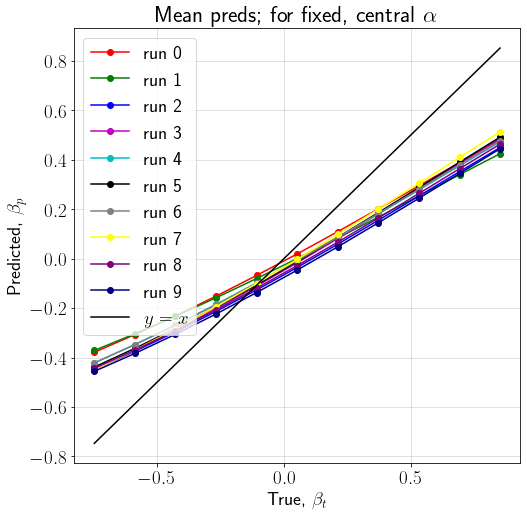

In [30]:
plt.figure(figsize=(8,8))
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'grey', 'yellow', 'purple', 'navy']
for i in range(N_members_committee):
    # plt.scatter(true_betas, Betas[i], color = 'g', s = 4, label = r'Point preds $\beta$, '+f'ext{i}', alpha = 0.4)
    # plt.errorbar(true_betas[::N_skewers_each_test], means_beta, yerr = sigs_beta, label = 'Mean predictions', fmt = '-o', color = 'k', capsize = 10)
    plt.plot(true_betas[::N_skewers_each_test], Mean_betas[i], '-o', label = f'run {i}', color = colors[i])
    # plt.fill_between(true_betas[::N_skewers_each_test], mins_beta,maxs_beta, label = 'Coverage 68\%', color = 'c',alpha=0.5)

plt.plot(true_betas, true_betas, label = "$y=x$", color = 'k')
plt.title(r"Mean preds; for fixed, central $\alpha$")
plt.xlabel(r"True, $\beta_t$")
plt.ylabel(r"Predicted, $\beta_p$")
plt.grid(alpha = 0.5)
plt.legend();

In [31]:
True_betas = [] #, []
for range_idx in range(2*11, 8*11 + 1, 11):
    t_beta = [] #, []
    for idx in range(range_idx, range_idx+11):
        sl   = np.s_[idx*N_skewers_each_test : (idx+1)*N_skewers_each_test]
        true = [T0s_orthogrid[idx], gammas_orthogrid[idx]]
        true_alpha, true_beta = change_basis(true[0], true[1])
        # t_alpha.append(true_alpha)
        t_beta.append(true_beta)
    # True_alphas.append(t_alpha)
    True_betas.append(t_beta)
# True_alpha = np.mean(np.array(True_alphas), axis = 0)
True_beta  = np.mean(np.array(True_betas), axis = 0)


Means_beta = [] #, []
# Sigs_alpha, Sigs_beta   = [], []
for i in range(N_members_committee):
    M_beta = [] #, []
    for range_idx in range(2*11, 8*11 + 1, 11):
        m_beta = [] #, []
        # s_alpha, s_beta = [], []
        for idx in range(range_idx, range_idx+11):
            sl   = np.s_[idx*N_skewers_each_valid : (idx+1)*N_skewers_each_valid]        
            pred_alpha, pred_beta = change_basis(rsansa_committee_predictions[i, sl, 0], rsansa_committee_predictions[i, sl, 1])
            # m_alpha.append(np.mean(pred_alpha))
            m_beta.append(np.mean(pred_beta))
            # s_alpha.append(np.std(pred_alpha))
            # s_beta.append(np.std(pred_beta))

        # M_alpha.append(m_alpha)
        M_beta.append(m_beta)
        # Sigs_alpha.append(s_alpha)
        # Sigs_beta.append(s_beta)
    # Means_alpha.append(np.mean(M_alpha, axis = 0))
    Means_beta.append(np.mean(M_beta, axis = 0))

# Means_alpha = np.array(Means_alpha) #, axis = 0)
Means_beta  = np.array(Means_beta) #, axis = 0)

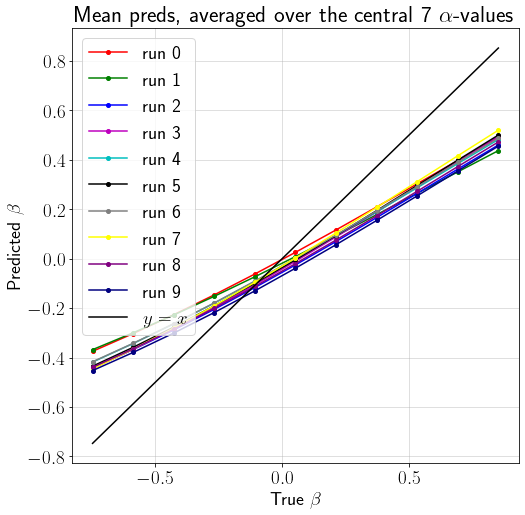

In [32]:
plt.figure(figsize=(8,8))
# colors = ['r', 'g', 'b', 'm']
for i in range(N_members_committee):
    plt.plot(True_beta, Means_beta[i], '-o', color = colors[i], label = f'run {i}', markersize = 4,) #, capsize = 10)
plt.plot(True_beta, True_beta, label = "$y=x$", color = 'k')
plt.xlabel(r"True $\beta$")
plt.ylabel(r"Predicted $\beta$")
plt.grid(alpha = 0.5)
plt.title(r"Mean preds, averaged over the central 7 $\alpha$-values")
plt.legend();

In [32]:
range_start   = 5
true_alphas = [] #, []
for idx in range(range_start, 110+range_start+1, 11):
    sl   = np.s_[idx*N_skewers_each_test : (idx+1)*N_skewers_each_test]
    true = test_spectra[sl, 512:514, 0]
    true_alpha, true_beta = change_basis(true[:, 0], true[:, 1])
    true_alphas.append(true_alpha)
    # true_betas.append(true_beta)
true_alphas = np.ravel(np.array(true_alphas))
# true_betas  = np.ravel(np.array(true_betas))

Alphas      = [] #, []
Mean_alphas = [] #, []
Sig_alphas  = [] #, []
Min_alphas, Max_alphas = [], []
for i in range(N_members_committee):
    alphas      = [] #, []
    means_alpha = [] #, []
    sigs_alpha  = [] #, []
    mins_alpha, maxs_alpha = [], []
    for idx in range(range_start, 110+range_start+1, 11):
        sl   = np.s_[idx*N_skewers_each_valid : (idx+1)*N_skewers_each_valid]
        # true      = test_spectra[sl, 512:514, 0] #[T0s_orthogrid[idx], gammas_orthogrid[idx]]
        pred_alpha, pred_beta = change_basis(rsansa_committee_predictions[i, sl, 0], rsansa_committee_predictions[i, sl, 1])
        # plt.figure() 
        # plt.hist(pred_beta, bins = 100)#'auto')
        hist,bins=np.histogram(pred_alpha,bins=100)#'auto')
        bins=bins[:-1]
        bins+=np.diff(bins)[0]/2
        cumulative_ind=np.argsort(hist)
        cumulative_y=np.cumsum(hist[cumulative_ind])/np.sum(hist)
        select=cumulative_y>=0.317
        min_conf,max_conf=bins[cumulative_ind][select].min(),bins[cumulative_ind][select].max()

        alphas.append(pred_alpha)
        # betas.append(pred_beta)
        mean_alpha = np.mean(pred_alpha)
        # mean_beta  = np.mean(pred_beta)
        sig_alpha  = np.std(pred_alpha)
        # sig_beta   = np.std(pred_beta)
        # plt.axvline(true_beta[0], color = 'k')
        # plt.axvline(mean_beta, color = 'g')
        # plt.fill_betweenx([0,300], mean_beta-sig_beta, mean_beta+sig_beta,alpha=0.5,color='r',zorder=5)
        # plt.fill_betweenx([0,hist[cumulative_ind[select]].min()], min_conf, max_conf,alpha=0.5,color='g',zorder=5)
        means_alpha.append(mean_alpha)
        # means_beta.append(mean_beta)
        mins_alpha.append(min_conf)
        maxs_alpha.append(max_conf)
        sigs_alpha.append(sig_alpha)
        # sigs_beta.append(sig_beta)
    Alphas.append(alphas); 
    #Betas.append(betas)
    Mean_alphas.append(means_alpha); 
    # Mean_betas.append(means_beta)
    Min_alphas.append(mins_alpha); 
    Max_alphas.append(maxs_alpha)
    Sig_alphas.append(sigs_alpha); 
    # Sig_betas.append(sigs_beta)
    
Alphas = np.array(Alphas).reshape(N_members_committee, -1) #np.ravel(np.array(alphas))
# Betas  = np.array(Betas).reshape(len(rsansa_preds), -1)
Mean_alphas = np.array(Mean_alphas); 
# Mean_betas = np.array(Mean_betas)
Sig_alphas = np.array(Sig_alphas); 
# Sig_betas = np.array(Sig_betas)

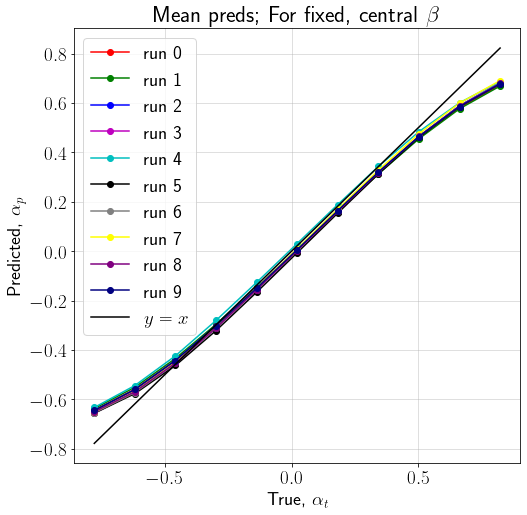

In [34]:
plt.figure(figsize=(8,8))
# colors = ['r', 'g', 'b', 'm']
for i in range(N_members_committee):
    # plt.scatter(true_betas, Betas[i], color = 'g', s = 4, label = r'Point preds $\beta$, '+f'ext{i}', alpha = 0.4)
    # plt.errorbar(true_betas[::N_skewers_each_test], means_beta, yerr = sigs_beta, label = 'Mean predictions', fmt = '-o', color = 'k', capsize = 10)
    plt.plot(true_alphas[::N_skewers_each_test], Mean_alphas[i], '-o', label = f'run {i}', color = colors[i])
    # plt.fill_between(true_betas[::N_skewers_each_test], mins_beta,maxs_beta, label = 'Coverage 68\%', color = 'c',alpha=0.5)

plt.plot(true_alphas, true_alphas, label = "$y=x$", color = 'k')
plt.title(r"Mean preds; For fixed, central $\beta$")
plt.xlabel(r"True, $\alpha_t$")
plt.ylabel(r"Predicted, $\alpha_p$")
plt.grid(alpha = 0.5)
plt.legend();

In [33]:
True_alphas = [] #, []
for range_start in range(2, 9):
    t_alpha = [] #, []
    for idx in range(range_start, 110+range_start+1, 11):
        sl   = np.s_[idx*N_skewers_each_test : (idx+1)*N_skewers_each_test]
        true = [T0s_orthogrid[idx], gammas_orthogrid[idx]]
        true_alpha, true_beta = change_basis(true[0], true[1])
        t_alpha.append(true_alpha)
        # t_beta.append(true_beta)
    True_alphas.append(t_alpha)
    # True_betas.append(t_beta)
True_alpha = np.mean(np.array(True_alphas), axis = 0)
# True_beta  = np.mean(np.array(True_betas), axis = 0)


Means_alpha = [] #, []
# Sigs_alpha, Sigs_beta   = [], []
for i in range(N_members_committee):
    M_alpha = [] #, []
    for range_start in range(2, 9):
        m_alpha = [] #, []
        # s_alpha, s_beta = [], []
        for idx in range(range_start, 110+range_start+1, 11):
            sl   = np.s_[idx*N_skewers_each_valid : (idx+1)*N_skewers_each_valid]        
            pred_alpha, pred_beta = change_basis(rsansa_committee_predictions[i, sl, 0], rsansa_committee_predictions[i, sl, 1])
            m_alpha.append(np.mean(pred_alpha))
            # m_beta.append(np.mean(pred_beta))
            # s_alpha.append(np.std(pred_alpha))
            # s_beta.append(np.std(pred_beta))

        M_alpha.append(m_alpha)
        # M_beta.append(m_beta)
        # Sigs_alpha.append(s_alpha)
        # Sigs_beta.append(s_beta)
    Means_alpha.append(np.mean(M_alpha, axis = 0))
    # Means_beta.append(np.mean(M_beta, axis = 0))

Means_alpha = np.array(Means_alpha) #, axis = 0)
# Means_beta  = np.array(Means_beta) #, axis = 0)

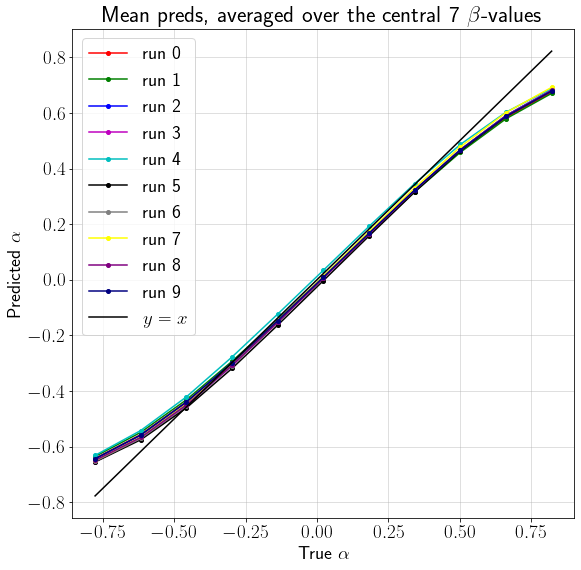

In [36]:
plt.figure(figsize=(9,9))
# colors = ['r', 'g', 'b', 'm']
for i in range(N_members_committee):
    plt.plot(True_alpha, Means_alpha[i], '-o', color = colors[i], label = f'run {i}', markersize = 4,) #, capsize = 10)
plt.plot(True_alpha, True_alpha, label = "$y=x$", color = 'k')
plt.xlabel(r"True $\alpha$")
plt.ylabel(r"Predicted $\alpha$")
plt.grid(alpha = 0.5)
plt.title(r"Mean preds, averaged over the central 7 $\beta$-values")
plt.legend();

### Fitting straight lines through predicted ($\alpha$, $\beta$)

In [34]:
ms_fit_inv_b, cs_fit_inv_b = [], []
for i in range(N_members_committee):
    mean_betas_to_fit = Means_beta[i]
    # print(Mean_beta[1:10].shape)
    true_betas_to_fit = True_beta #true_betas[::N_skewers_each_test]
    # mean_betas_to_fit.shape, true_betas_to_fit.shape

    m_fit_inv_b, c_fit_inv_b = np.polyfit(mean_betas_to_fit[2:9], true_betas_to_fit[2:9], 1)
    ms_fit_inv_b.append(m_fit_inv_b)
    cs_fit_inv_b.append(c_fit_inv_b)
    # print(f"Fitting function: {m_fit_inv_b:.4f}x + {c_fit_inv_b:.4f}")

In [35]:
ms_fit_inv_a, cs_fit_inv_a = [], []
for i in range(N_members_committee):
    mean_alphas_to_fit = Means_alpha[i]
    true_alphas_to_fit = True_alpha #true_alphas[::N_skewers_each_test]
    # mean_betas_to_fit.shape, true_betas_to_fit.shape

    m_fit_inv_a, c_fit_inv_a = np.polyfit(mean_alphas_to_fit[2:9], true_alphas_to_fit[2:9], 1)
    ms_fit_inv_a.append(m_fit_inv_a)
    cs_fit_inv_a.append(c_fit_inv_a)
    # print(f"Fitting function: {m_fit_inv_a:.4f}x {c_fit_inv_a:.4f}")

In [36]:
V         = np.array([v0, v1])                   #; print(V)
Ws_rsansa = []
Ds_rsansa = []
for i in range(N_members_committee):
    M_rsansa  = np.diag([ms_fit_inv_a[i], ms_fit_inv_b[i]])  #; print(M)
    W_rsansa  = V.dot(M_rsansa.dot(V))                      #; print(W)
    Ws_rsansa.append(W_rsansa)
    c_array_rsansa  = np.array([cs_fit_inv_a[i], cs_fit_inv_b[i]]) #; print(c_array)
    D_array_rsansa  = c_array_rsansa.dot(V)                       #; print(D_array)
    Ds_rsansa.append(D_array_rsansa)
    W_inv    = np.linalg.inv(W_rsansa)                     #; print(W, np.linalg.inv(W))
Ws_rsansa = np.array(Ws_rsansa)
Ds_rsansa = np.array(Ds_rsansa)

In [55]:
Ws_rsansa.shape, Ds_rsansa.shape
np.save(op_path+f'retraining_tuner_impl_{kt_impl_id}/rsansa_committee_W_matrices_retrained_kt{kt_impl_id}_{N_members_committee}runs.npy', Ws_rsansa)
np.save(op_path+f'retraining_tuner_impl_{kt_impl_id}/rsansa_committee_D_vectors_retrained_kt{kt_impl_id}_{N_members_committee}runs.npy', Ds_rsansa);

## Linearly transforming point predictions

In [29]:
rsansa_transformed_committee_predictions = np.zeros_like(rsansa_committee_predictions)
for i in range(N_members_committee):
    rsansa_transformed_committee_predictions[i,:,0] = Ws_rsansa[i,0,0]*rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,0,1]*rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,0]
    rsansa_transformed_committee_predictions[i,:,1] = Ws_rsansa[i,0,1]*rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,1,1]*rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,1]
# mean_rsansa_transformed_committee_predictions = np.mean(rsansa_transformed_committee_predictions, axis = 0)

In [30]:
test_rsansa_transformed_committee_predictions = np.zeros_like(test_rsansa_committee_predictions)
for i in range(N_members_committee):
    test_rsansa_transformed_committee_predictions[i,:,0] = Ws_rsansa[i,0,0]*test_rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,0,1]*test_rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,0]
    test_rsansa_transformed_committee_predictions[i,:,1] = Ws_rsansa[i,0,1]*test_rsansa_committee_predictions[i,:,0] + Ws_rsansa[i,1,1]*test_rsansa_committee_predictions[i,:,1] + Ds_rsansa[i,1]
# mean_test_rsansa_transformed_committee_predictions = np.mean(test_rsansa_transformed_committee_predictions, axis = 0)

In [31]:
mean_rsansa_transformed_committee_predictions      = np.average(rsansa_transformed_committee_predictions, axis = 0, weights = 1./committee_transformed_network_covariance_determinants)
mean_test_rsansa_transformed_committee_predictions = np.average(test_rsansa_transformed_committee_predictions, axis = 0, weights = 1./test_committee_transformed_network_covariance_determinants)

In [32]:
rsansa_transformed_committee_predictions.shape, test_rsansa_transformed_committee_predictions.shape

((10, 968000, 5), (10, 484000, 5))

In [33]:
mean_rsansa_transformed_committee_predictions.shape, mean_test_rsansa_transformed_committee_predictions.shape

((968000, 5), (484000, 5))

In [34]:
# rSansa

Means_rsansa_test = []
# Invcovs_rsansa    = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test, :2]
    rsansa_point_estimates = mean_test_rsansa_transformed_committee_predictions[tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    Means_rsansa_test.append(rsansa_mean_estimates)
    # Invcovs_rsansa.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_test = np.array(Means_rsansa_test)

In [35]:
Means_rsansa_test.shape

(121, 2)

## Creating a likelihood model for rSansa Committee

In [36]:
# rSansa
N_rSansa = 100

Means_rsansa_committee_interpolation    = []
Invcovs_rsansa_committee  = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_valid : (idx_of_inference_tester+1)*N_skewers_each_valid, :2]
    rsansa_point_estimates = mean_rsansa_transformed_committee_predictions[tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    # print(dsansa_mean_estimates)
    rsansa_covariance_estimate = np.cov(rsansa_point_estimates, rowvar = False)/N_rSansa
    # print(dsansa_covariance_estimate)
    Means_rsansa_committee_interpolation.append(rsansa_mean_estimates)
    Invcovs_rsansa_committee.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_committee_interpolation    = np.array(Means_rsansa_committee_interpolation)
Invcovs_rsansa_committee  = np.array(Invcovs_rsansa_committee)
Means_rsansa_committee_interpolation.shape, Invcovs_rsansa_committee.shape

((121, 2), (121, 2, 2))

In [37]:
order_interp = 3
mean_T0_interpolator_rsansa_committee = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_committee_interpolation[:,0].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

mean_gamma_interpolator_rsansa_committee = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_committee_interpolation[:,1].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

invcov_interpolators_rsansa_committee = []
for i in [0,1,3]:
    invcov_interpolators_rsansa_committee.append(
        RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Invcovs_rsansa_committee[:,i//2, i%2].reshape(11,11),
            kx = order_interp, ky = order_interp,
        )
    )

In [52]:
N_grid      = 100
alphas_test = np.linspace(min(Oracle.alphas)+0.15, max(Oracle.alphas)-0.15, N_grid)
betas_test  = np.linspace(min(Oracle.betas)+0.05,  max(Oracle.betas)-0.05,  N_grid)

# T0s_test, gammas_test    = change_basis(alphas_test, betas_test)

# T0s_testm, gammas_testm = np.meshgrid(T0s_test, gammas_test)
alphas_m, betas_m = np.meshgrid(alphas_test, betas_test)
alphas_m = np.ravel(alphas_m); betas_m = np.ravel(betas_m)

T0s_testm, gammas_testm = change_basis(alphas_m, betas_m)

logdetC     = np.zeros(T0s_testm.shape)
T0_model    = np.zeros(T0s_testm.shape)
gamma_model = np.zeros(T0s_testm.shape)
for i in range(len(T0s_testm)):
    # for j in range(len(gammas_test)):
        # alpha, beta = change_basis(T0s_test[i], gammas_test[j])
    C00 = invcov_interpolators_rsansa_committee[0](alphas_m[i], betas_m[i])[0,0]
    C01 = invcov_interpolators_rsansa_committee[1](alphas_m[i], betas_m[i])[0,0]
    C11 = invcov_interpolators_rsansa_committee[2](alphas_m[i], betas_m[i])[0,0]
    logdetC[i]  = -np.log(C00*C11 - C01**2) 
    T0_model[i] = mean_T0_interpolator_rsansa_committee(alphas_m[i], betas_m[i])[0,0]
    gamma_model[i] = mean_gamma_interpolator_rsansa_committee(alphas_m[i], betas_m[i])[0,0]

T0s_testm    = T0s_testm.reshape(N_grid,N_grid)
gammas_testm = gammas_testm.reshape(N_grid,N_grid)
logdetC      = logdetC.reshape(N_grid,N_grid)
T0_model     = T0_model.reshape(N_grid, N_grid)
gamma_model  = gamma_model.reshape(N_grid, N_grid)

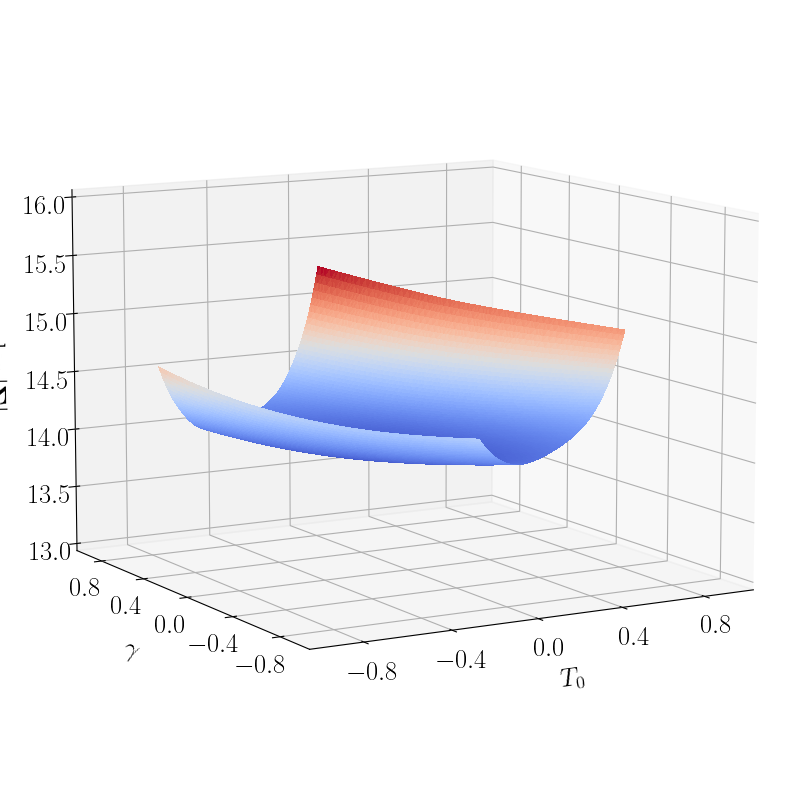

In [55]:
fig = plt.figure(figsize = (10,13))
ax  = fig.subplots(subplot_kw={"projection":"3d"})
ax.view_init(elev = 10, azim = 240)
T0s_test    = np.ravel(T0s_testm)
gammas_test = np.ravel(gammas_testm)
surf = ax.plot_trisurf(T0s_test, gammas_test, -np.ravel(logdetC), linewidth = 0, antialiased = False, cmap = 'coolwarm', alpha = 1.0)
# surf = ax.plot_surface(alphas_m, betas_m, logdetC, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf1 = ax.plot_surface(T0s_testm, gammas_testm, T0_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf2 = ax.plot_surface(alphas_m, betas_m, gamma_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# ax.scatter3D(T0s_orthogrid, gammas_orthogrid, np.ones(T0s_orthogrid.shape)*13.5, color = 'k', s = 4, alpha = 1.0)
filled = (T0s_testm<max(T0s_orthogrid))&(T0s_testm>min(T0s_orthogrid))&(gammas_testm<max(gammas_orthogrid))&(gammas_testm>min(gammas_orthogrid))
# ax.voxels(filled, facecolors = [0,0,0,0.5])# -1.*np.ones(len(T0s_orthogrid)), 1.*np.ones(len(T0s_orthogrid)), alpha = 0.3, color = 'grey')
# ax.scatter3D(T0s_testm, gammas_testm, gammas_testm, color = 'k', s = 1, alpha = 0.3)
# ax.set_zlim3d(1000, 12000)
# ax.set_zscale('log')
# ax.set_xlabel(r'$\alpha$')
ax.set_xlabel('$T_0$', labelpad = 15)
# ax.set_ylabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$', labelpad = 15)
ax.set_zlabel(r'$-\log \vert \mathbf{\Sigma} \vert$', labelpad = 15)
ax.set_xlim(-1.0, 1.0)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(13, 16);
# ax.set_zticks([16, 15, 14,]);
# fig.colorbar(surf, shrink = 0.5, location = 'left');
# plt.tight_layout();
# ax.grid(alpha = 0.3)
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')

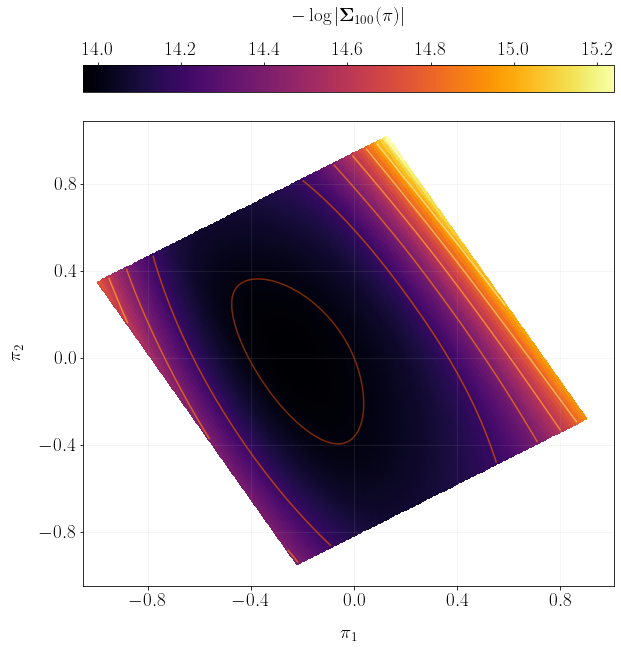

In [64]:
fig = plt.figure(figsize = (9,9.5))
ax  = fig.subplots(1) #subplot_kw={"projection":"3d"})
con = ax.contour(T0s_testm, gammas_testm, -logdetC, alpha = 0.8, cmap = 'YlOrBr_r', levels = 6)
pcm = ax.pcolormesh(T0s_testm, gammas_testm, -logdetC, cmap = 'inferno', shading = 'auto', rasterized = True)
ax.grid(alpha = 0.15)
# ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
ax.set_xlabel(r'$\pi_1$', labelpad = 15)
ax.set_ylabel(r'$\pi_2$', labelpad = 15)

ax.set_xlim(-1.05, 1.01)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.05, 1.09);
cp = plt.colorbar(pcm, ax = ax, shrink = 1.0, location = 'top');
cp.set_label(label = r'$-\log \vert \mathbf{\Sigma}_{100} (\pi) \vert$', labelpad = 20)
plt.tight_layout();
# cc = plt.colorbar(con, cax = cp.ax, orientation = 'horizontal');
# plt.savefig(op_path+'figures/committee_likelihood_model_C_presentation_version.pdf', bbox_inches = 'tight', dpi = 300)

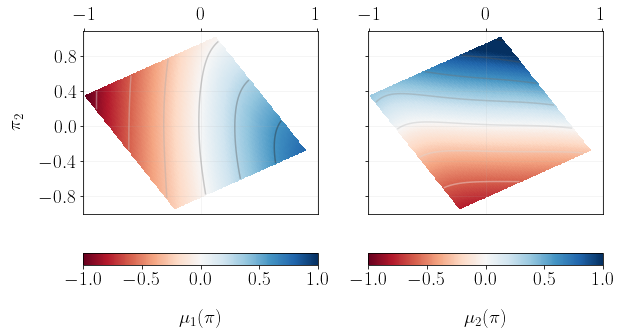

In [49]:
fig  = plt.figure(figsize=(9,5))
axs  = fig.subplots(1, 2, sharey = True) #subplot_kw={"projection":"3d"})
con0 = axs[0].contour(T0s_testm, gammas_testm, T0_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm0 = axs[0].pcolormesh(T0s_testm, gammas_testm, T0_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[0].set_xlabel(r'$\mu_1$', labelpad = 15)
axs[0].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[0].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[0].set_xlim(-1.01, 1.01)
# axs[0].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_ylim(-1.01, 1.09)
axs[0].grid(alpha = 0.15);
cb1 = plt.colorbar(pcm0, ax = axs[0], shrink = 1.0, location = 'bottom')
cb1.set_label(label = r'$\mu_1 (\pi)$', labelpad = 20);


# plt.subplot(2,2,4) #subplot_kw={"projection":"3d"})
con1 = axs[1].contour(T0s_testm, gammas_testm, gamma_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm1 = axs[1].pcolormesh(T0s_testm, gammas_testm, gamma_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[1].set_xlabel(r'$\mu_1$', labelpad = 15)
# axs[1].set_ylabel(r'$\mu_2$', labelpad = 15)
axs[1].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[1].set_xlim(-1.01, 1.01)
# axs[1].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_ylim(-1.01, 1.09)
axs[1].grid(alpha = 0.15);
cb2 = plt.colorbar(pcm1, ax = axs[1], shrink = 1.0, location = 'bottom')
# cc = plt.colorbar(con1, cax = cb2.ax, orientation = 'horizontal');
cb2.set_label(label = r'$\mu_2 (\pi)$', labelpad = 20);
plt.tight_layout();
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')
# plt.savefig(op_path+'figures/committee_likelihood_model_mu.pdf', bbox_inches = 'tight', dpi = 300)

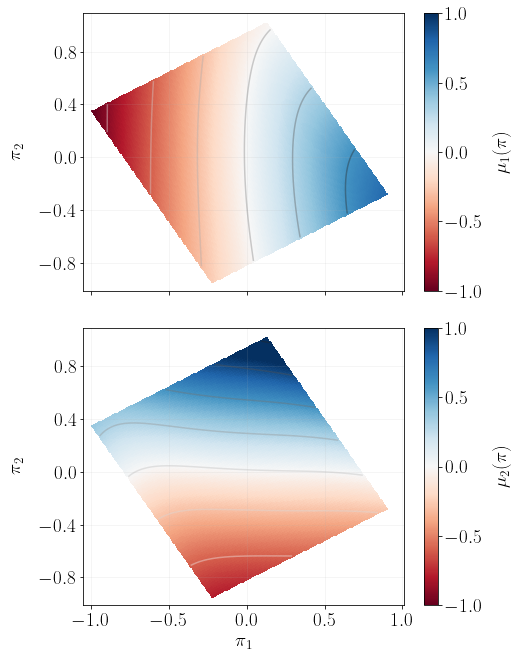

In [65]:
fig  = plt.figure(figsize=(7.5,9.5))
axs  = fig.subplots(2, 1, sharex = True) #subplot_kw={"projection":"3d"})
con0 = axs[0].contour(T0s_testm, gammas_testm, T0_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm0 = axs[0].pcolormesh(T0s_testm, gammas_testm, T0_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[0].set_xlabel(r'$\mu_1$', labelpad = 15)
axs[0].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[0].tick_params(top = False, labeltop = False, bottom = True, labelbottom = False)
axs[0].set_xlim(-1.05, 1.01)
# axs[0].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_ylim(-1.01, 1.09)
axs[0].grid(alpha = 0.15);
cb1 = plt.colorbar(pcm0, ax = axs[0], shrink = 1.0, location = 'right')
cb1.set_label(label = r'$\mu_1 (\pi)$', labelpad = 10);


# plt.subplot(2,2,4) #subplot_kw={"projection":"3d"})
con1 = axs[1].contour(T0s_testm, gammas_testm, gamma_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm1 = axs[1].pcolormesh(T0s_testm, gammas_testm, gamma_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[1].set_xlabel(r'$\mu_1$', labelpad = 15)
# axs[1].set_ylabel(r'$\mu_2$', labelpad = 15)
axs[1].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[1].tick_params(top = False, labeltop = False, bottom = True, labelbottom = True)
axs[1].set_xlabel(r'$\pi_1$')
axs[1].set_xlim(-1.05, 1.01)
# axs[1].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_ylim(-1.01, 1.09)
axs[1].grid(alpha = 0.15);
cb2 = plt.colorbar(pcm1, ax = axs[1], shrink = 1.0, location = 'right')
# cc = plt.colorbar(con1, cax = cb2.ax, orientation = 'horizontal');
cb2.set_label(label = r'$\mu_2 (\pi)$', labelpad = 10);
plt.tight_layout();
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')
# plt.savefig(op_path+'figures/committee_likelihood_model_mu_presentation_version.pdf', bbox_inches = 'tight', dpi = 300)

In [105]:
# Fiducial test case

idx_of_inference_tester = 36
def compute_likelihood_rsansa(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.array([Means_rsansa_interpolation[idx_of_inference_tester, 0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa(alpha, beta)[0,0], mean_gamma_interpolator_rsansa(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa(*x))

p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0s_orthogrid[idx_of_inference_tester], gammas_orthogrid[idx_of_inference_tester]]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa    = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain = sampler_rsansa.flatchain[500000:,:]

means_rsansa_flatchain    = np.mean(rsansa_flatchain, axis = 0)
rsansa_deltachain         = rsansa_flatchain - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(1) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_upscaled[:,0] = rescale_T0(rsansa_flatchain_committee_upscaled[:,0], mode = 'up')
rsansa_flatchain_committee_upscaled[:,1] = rescale_gamma(rsansa_flatchain_committee_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_upscaled[:,0] = rsansa_flatchain_committee_upscaled[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_upscaled[:,1] = rsansa_flatchain_committee_upscaled[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

## Creating a likelihood model for rSansa Best Network in the Committee

In [40]:
best_network_idx = 7

In [41]:
# rSansa
N_rSansa = 1000

Means_rsansa_interpolation_best    = []
Invcovs_rsansa_best  = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_valid : (idx_of_inference_tester+1)*N_skewers_each_valid, :2]
    rsansa_point_estimates = rsansa_transformed_committee_predictions[best_network_idx][tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    # print(dsansa_mean_estimates)
    rsansa_covariance_estimate = np.cov(rsansa_point_estimates, rowvar = False)/N_rSansa
    # print(dsansa_covariance_estimate)
    Means_rsansa_interpolation_best.append(rsansa_mean_estimates)
    Invcovs_rsansa_best.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_interpolation_best    = np.array(Means_rsansa_interpolation_best)
Invcovs_rsansa_best  = np.array(Invcovs_rsansa_best)
Means_rsansa_interpolation_best.shape, Invcovs_rsansa_best.shape

((121, 2), (121, 2, 2))

In [42]:
order_interp = 3
mean_T0_interpolator_rsansa_best = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_interpolation_best[:,0].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

mean_gamma_interpolator_rsansa_best = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_interpolation_best[:,1].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

invcov_interpolators_rsansa_best = []
for i in [0,1,3]:
    invcov_interpolators_rsansa_best.append(
        RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Invcovs_rsansa_best[:,i//2, i%2].reshape(11,11),
            kx = order_interp, ky = order_interp,
        )
    )

In [48]:
N_grid      = 100
alphas_test = np.linspace(min(Oracle.alphas)+0.15, max(Oracle.alphas)-0.15, N_grid)
betas_test  = np.linspace(min(Oracle.betas)+0.05,  max(Oracle.betas)-0.05,  N_grid)

# T0s_test, gammas_test    = change_basis(alphas_test, betas_test)

# T0s_testm, gammas_testm = np.meshgrid(T0s_test, gammas_test)
alphas_m, betas_m = np.meshgrid(alphas_test, betas_test)
alphas_m = np.ravel(alphas_m); betas_m = np.ravel(betas_m)

T0s_testm, gammas_testm = change_basis(alphas_m, betas_m)

logdetC     = np.zeros(T0s_testm.shape)
T0_model    = np.zeros(T0s_testm.shape)
gamma_model = np.zeros(T0s_testm.shape)
for i in range(len(T0s_testm)):
    # for j in range(len(gammas_test)):
        # alpha, beta = change_basis(T0s_test[i], gammas_test[j])
    C00 = invcov_interpolators_rsansa_best[0](alphas_m[i], betas_m[i])[0,0]
    C01 = invcov_interpolators_rsansa_best[1](alphas_m[i], betas_m[i])[0,0]
    C11 = invcov_interpolators_rsansa_best[2](alphas_m[i], betas_m[i])[0,0]
    logdetC[i]  = -np.log(C00*C11 - C01**2) 
    T0_model[i] = mean_T0_interpolator_rsansa_best(alphas_m[i], betas_m[i])[0,0]
    gamma_model[i] = mean_gamma_interpolator_rsansa_best(alphas_m[i], betas_m[i])[0,0]

T0s_testm    = T0s_testm.reshape(N_grid,N_grid)
gammas_testm = gammas_testm.reshape(N_grid,N_grid)
logdetC      = logdetC.reshape(N_grid,N_grid)
T0_model     = T0_model.reshape(N_grid, N_grid)
gamma_model  = gamma_model.reshape(N_grid, N_grid)

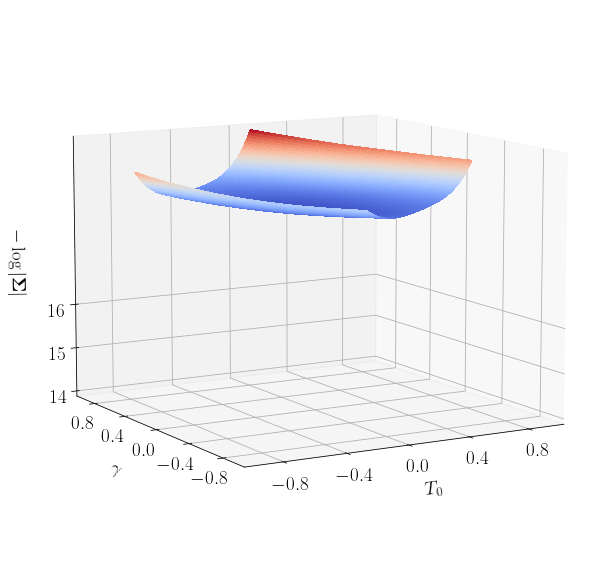

In [49]:
fig = plt.figure(figsize = (10,13))
ax  = fig.subplots(subplot_kw={"projection":"3d"})
ax.view_init(elev = 10, azim = 240)
T0s_test    = np.ravel(T0s_testm)
gammas_test = np.ravel(gammas_testm)
surf = ax.plot_trisurf(T0s_test, gammas_test, -np.ravel(logdetC), linewidth = 0, antialiased = False, cmap = 'coolwarm', alpha = 1.0)
# surf = ax.plot_surface(alphas_m, betas_m, logdetC, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf1 = ax.plot_surface(T0s_testm, gammas_testm, T0_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf2 = ax.plot_surface(alphas_m, betas_m, gamma_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# ax.scatter3D(T0s_orthogrid, gammas_orthogrid, np.ones(T0s_orthogrid.shape)*13.5, color = 'k', s = 4, alpha = 1.0)
filled = (T0s_testm<max(T0s_orthogrid))&(T0s_testm>min(T0s_orthogrid))&(gammas_testm<max(gammas_orthogrid))&(gammas_testm>min(gammas_orthogrid))
# ax.voxels(filled, facecolors = [0,0,0,0.5])# -1.*np.ones(len(T0s_orthogrid)), 1.*np.ones(len(T0s_orthogrid)), alpha = 0.3, color = 'grey')
# ax.scatter3D(T0s_testm, gammas_testm, gammas_testm, color = 'k', s = 1, alpha = 0.3)
# ax.set_zlim3d(1000, 12000)
# ax.set_zscale('log')
# ax.set_xlabel(r'$\alpha$')
ax.set_xlabel('$T_0$', labelpad = 15)
# ax.set_ylabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$', labelpad = 15)
ax.set_zlabel(r'$-\log \vert \mathbf{\Sigma} \vert$', labelpad = 15)
ax.set_xlim(-1.0, 1.0)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.0, 1.0)
# ax.set_zlim(13.5, 16.8)
ax.set_zticks([16, 15, 14,]);
# fig.colorbar(surf, shrink = 0.5, location = 'left');
# plt.tight_layout();
# ax.grid(alpha = 0.3)
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')

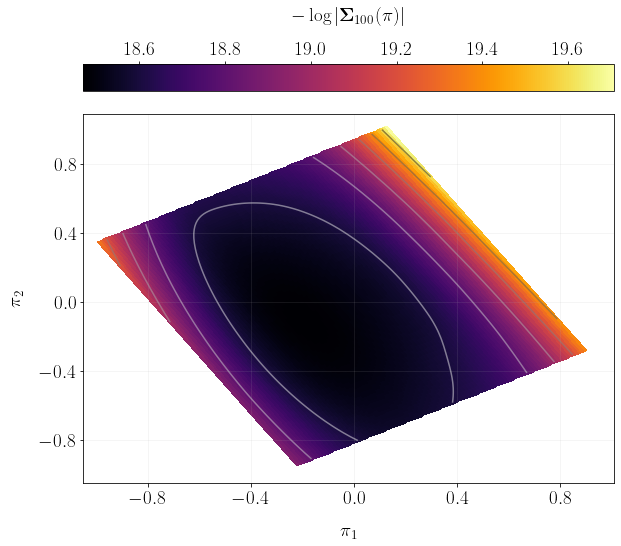

In [50]:
fig = plt.figure(figsize = (9,8))
ax  = fig.subplots(1) #subplot_kw={"projection":"3d"})
con = ax.contour(T0s_testm, gammas_testm, -logdetC, alpha = 0.5, cmap = 'Greys', levels = 6)
pcm = ax.pcolormesh(T0s_testm, gammas_testm, -logdetC, cmap = 'inferno', shading = 'auto', rasterized = True)
ax.grid(alpha = 0.15)
# ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
ax.set_xlabel(r'$\pi_1$', labelpad = 15)
ax.set_ylabel(r'$\pi_2$', labelpad = 15)

ax.set_xlim(-1.05, 1.01)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.05, 1.09);
cp = plt.colorbar(pcm, ax = ax, shrink = 1.0, location = 'top');
cp.set_label(label = r'$-\log \vert \mathbf{\Sigma}_{100} (\pi) \vert$', labelpad = 20)
plt.tight_layout();
# cc = plt.colorbar(con, cax = cp.ax, orientation = 'horizontal');
# plt.savefig(op_path+'figures/likelihood_model_C.pdf', bbox_inches = 'tight', dpi = 300)

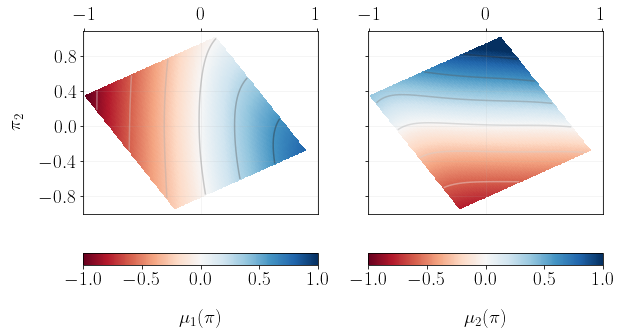

In [51]:
fig  = plt.figure(figsize=(9,5))
axs  = fig.subplots(1, 2, sharey = True) #subplot_kw={"projection":"3d"})
con0 = axs[0].contour(T0s_testm, gammas_testm, T0_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm0 = axs[0].pcolormesh(T0s_testm, gammas_testm, T0_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[0].set_xlabel(r'$\mu_1$', labelpad = 15)
axs[0].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[0].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[0].set_xlim(-1.01, 1.01)
# axs[0].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_ylim(-1.01, 1.09)
axs[0].grid(alpha = 0.15);
cb1 = plt.colorbar(pcm0, ax = axs[0], shrink = 1.0, location = 'bottom')
cb1.set_label(label = r'$\mu_1 (\pi)$', labelpad = 20);


# plt.subplot(2,2,4) #subplot_kw={"projection":"3d"})
con1 = axs[1].contour(T0s_testm, gammas_testm, gamma_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm1 = axs[1].pcolormesh(T0s_testm, gammas_testm, gamma_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[1].set_xlabel(r'$\mu_1$', labelpad = 15)
# axs[1].set_ylabel(r'$\mu_2$', labelpad = 15)
axs[1].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[1].set_xlim(-1.01, 1.01)
# axs[1].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_ylim(-1.01, 1.09)
axs[1].grid(alpha = 0.15);
cb2 = plt.colorbar(pcm1, ax = axs[1], shrink = 1.0, location = 'bottom')
# cc = plt.colorbar(con1, cax = cb2.ax, orientation = 'horizontal');
cb2.set_label(label = r'$\mu_2 (\pi)$', labelpad = 20);
plt.tight_layout();
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')
# plt.savefig(op_path+'figures/likelihood_model_mu.pdf', bbox_inches = 'tight', dpi = 300)

In [105]:
# Fiducial test case

idx_of_inference_tester = 36
def compute_likelihood_rsansa(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.array([Means_rsansa_interpolation[idx_of_inference_tester, 0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa(alpha, beta)[0,0], mean_gamma_interpolator_rsansa(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa(*x))

p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0s_orthogrid[idx_of_inference_tester], gammas_orthogrid[idx_of_inference_tester]]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa    = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain = sampler_rsansa.flatchain[500000:,:]

means_rsansa_flatchain    = np.mean(rsansa_flatchain, axis = 0)
rsansa_deltachain         = rsansa_flatchain - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(1) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_upscaled[:,0] = rescale_T0(rsansa_flatchain_committee_upscaled[:,0], mode = 'up')
rsansa_flatchain_committee_upscaled[:,1] = rescale_gamma(rsansa_flatchain_committee_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_upscaled[:,0] = rsansa_flatchain_committee_upscaled[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_upscaled[:,1] = rsansa_flatchain_committee_upscaled[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

## Creating a likelihood model for rSansa Least well-performing Network in the Committee

In [43]:
last_network_idx = 1

In [44]:
# rSansa
N_rSansa = 1000

Means_rsansa_interpolation_last    = []
Invcovs_rsansa_last  = []
for idx_of_inference_tester in range(len(hfiles)):
    tester_slice_rsansa    = np.s_[idx_of_inference_tester*N_skewers_each_valid : (idx_of_inference_tester+1)*N_skewers_each_valid, :2]
    rsansa_point_estimates = rsansa_transformed_committee_predictions[last_network_idx][tester_slice_rsansa] #arya_predictions[tester_slice_arya, :2]
    rsansa_mean_estimates  = np.mean(rsansa_point_estimates, axis = 0)
    # print(dsansa_mean_estimates)
    rsansa_covariance_estimate = np.cov(rsansa_point_estimates, rowvar = False)/N_rSansa
    # print(dsansa_covariance_estimate)
    Means_rsansa_interpolation_last.append(rsansa_mean_estimates)
    Invcovs_rsansa_last.append(np.linalg.inv(rsansa_covariance_estimate))
    
Means_rsansa_interpolation_last    = np.array(Means_rsansa_interpolation_last)
Invcovs_rsansa_last  = np.array(Invcovs_rsansa_last)
Means_rsansa_interpolation_last.shape, Invcovs_rsansa_last.shape

((121, 2), (121, 2, 2))

In [45]:
order_interp = 3
mean_T0_interpolator_rsansa_last = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_interpolation_last[:,0].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

mean_gamma_interpolator_rsansa_last = RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Means_rsansa_interpolation_last[:,1].reshape(11,11),
            kx = order_interp, ky = order_interp,
)

invcov_interpolators_rsansa_last = []
for i in [0,1,3]:
    invcov_interpolators_rsansa_last.append(
        RectBivariateSpline(
            Oracle.alphas[::11],
            Oracle.betas[:11],
            Invcovs_rsansa_last[:,i//2, i%2].reshape(11,11),
            kx = order_interp, ky = order_interp,
        )
    )

In [68]:
N_grid      = 100
alphas_test = np.linspace(min(Oracle.alphas)+0.15, max(Oracle.alphas)-0.15, N_grid)
betas_test  = np.linspace(min(Oracle.betas)+0.05,  max(Oracle.betas)-0.05,  N_grid)

# T0s_test, gammas_test    = change_basis(alphas_test, betas_test)

# T0s_testm, gammas_testm = np.meshgrid(T0s_test, gammas_test)
alphas_m, betas_m = np.meshgrid(alphas_test, betas_test)
alphas_m = np.ravel(alphas_m); betas_m = np.ravel(betas_m)

T0s_testm, gammas_testm = change_basis(alphas_m, betas_m)

logdetC     = np.zeros(T0s_testm.shape)
T0_model    = np.zeros(T0s_testm.shape)
gamma_model = np.zeros(T0s_testm.shape)
for i in range(len(T0s_testm)):
    # for j in range(len(gammas_test)):
        # alpha, beta = change_basis(T0s_test[i], gammas_test[j])
    C00 = invcov_interpolators_rsansa_last[0](alphas_m[i], betas_m[i])[0,0]
    C01 = invcov_interpolators_rsansa_last[1](alphas_m[i], betas_m[i])[0,0]
    C11 = invcov_interpolators_rsansa_last[2](alphas_m[i], betas_m[i])[0,0]
    logdetC[i]  = -np.log(C00*C11 - C01**2) 
    T0_model[i] = mean_T0_interpolator_rsansa_last(alphas_m[i], betas_m[i])[0,0]
    gamma_model[i] = mean_gamma_interpolator_rsansa_last(alphas_m[i], betas_m[i])[0,0]

T0s_testm    = T0s_testm.reshape(N_grid,N_grid)
gammas_testm = gammas_testm.reshape(N_grid,N_grid)
logdetC      = logdetC.reshape(N_grid,N_grid)
T0_model     = T0_model.reshape(N_grid, N_grid)
gamma_model  = gamma_model.reshape(N_grid, N_grid)

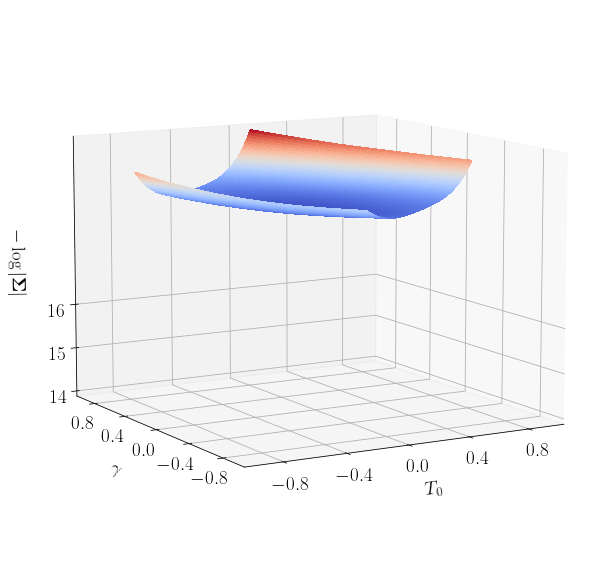

In [49]:
fig = plt.figure(figsize = (10,13))
ax  = fig.subplots(subplot_kw={"projection":"3d"})
ax.view_init(elev = 10, azim = 240)
T0s_test    = np.ravel(T0s_testm)
gammas_test = np.ravel(gammas_testm)
surf = ax.plot_trisurf(T0s_test, gammas_test, -np.ravel(logdetC), linewidth = 0, antialiased = False, cmap = 'coolwarm', alpha = 1.0)
# surf = ax.plot_surface(alphas_m, betas_m, logdetC, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf1 = ax.plot_surface(T0s_testm, gammas_testm, T0_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# surf2 = ax.plot_surface(alphas_m, betas_m, gamma_model, linewidth = 0, antialiased = False, cmap = 'RdBu')
# ax.scatter3D(T0s_orthogrid, gammas_orthogrid, np.ones(T0s_orthogrid.shape)*13.5, color = 'k', s = 4, alpha = 1.0)
filled = (T0s_testm<max(T0s_orthogrid))&(T0s_testm>min(T0s_orthogrid))&(gammas_testm<max(gammas_orthogrid))&(gammas_testm>min(gammas_orthogrid))
# ax.voxels(filled, facecolors = [0,0,0,0.5])# -1.*np.ones(len(T0s_orthogrid)), 1.*np.ones(len(T0s_orthogrid)), alpha = 0.3, color = 'grey')
# ax.scatter3D(T0s_testm, gammas_testm, gammas_testm, color = 'k', s = 1, alpha = 0.3)
# ax.set_zlim3d(1000, 12000)
# ax.set_zscale('log')
# ax.set_xlabel(r'$\alpha$')
ax.set_xlabel('$T_0$', labelpad = 15)
# ax.set_ylabel(r'$\beta$')
ax.set_ylabel(r'$\gamma$', labelpad = 15)
ax.set_zlabel(r'$-\log \vert \mathbf{\Sigma} \vert$', labelpad = 15)
ax.set_xlim(-1.0, 1.0)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.0, 1.0)
# ax.set_zlim(13.5, 16.8)
ax.set_zticks([16, 15, 14,]);
# fig.colorbar(surf, shrink = 0.5, location = 'left');
# plt.tight_layout();
# ax.grid(alpha = 0.3)
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')

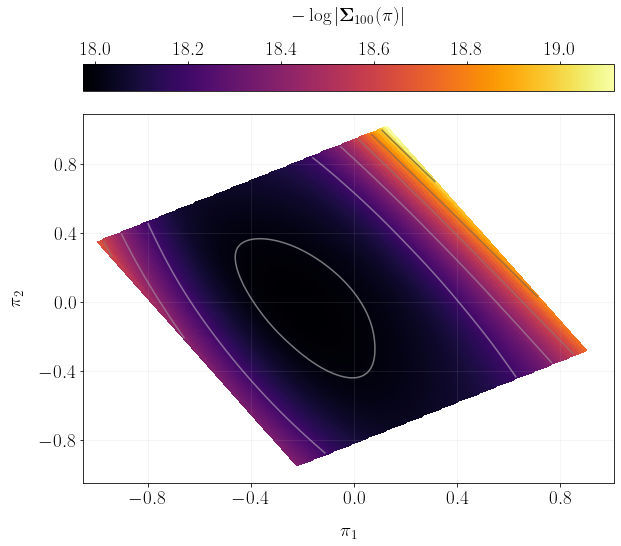

In [69]:
fig = plt.figure(figsize = (9,8))
ax  = fig.subplots(1) #subplot_kw={"projection":"3d"})
con = ax.contour(T0s_testm, gammas_testm, -logdetC, alpha = 0.5, cmap = 'Greys', levels = 6)
pcm = ax.pcolormesh(T0s_testm, gammas_testm, -logdetC, cmap = 'inferno', shading = 'auto', rasterized = True)
ax.grid(alpha = 0.15)
# ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
ax.set_xlabel(r'$\pi_1$', labelpad = 15)
ax.set_ylabel(r'$\pi_2$', labelpad = 15)

ax.set_xlim(-1.05, 1.01)
ax.set_xticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_yticks([-0.8,-0.4,0.,0.4,0.8])
ax.set_ylim(-1.05, 1.09);
cp = plt.colorbar(pcm, ax = ax, shrink = 1.0, location = 'top');
cp.set_label(label = r'$-\log \vert \mathbf{\Sigma}_{100} (\pi) \vert$', labelpad = 20)
plt.tight_layout();
# cc = plt.colorbar(con, cax = cp.ax, orientation = 'horizontal');
# plt.savefig(op_path+'figures/likelihood_model_C.pdf', bbox_inches = 'tight', dpi = 300)

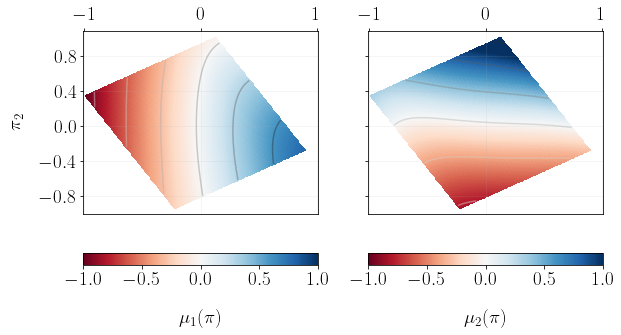

In [70]:
fig  = plt.figure(figsize=(9,5))
axs  = fig.subplots(1, 2, sharey = True) #subplot_kw={"projection":"3d"})
con0 = axs[0].contour(T0s_testm, gammas_testm, T0_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm0 = axs[0].pcolormesh(T0s_testm, gammas_testm, T0_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[0].set_xlabel(r'$\mu_1$', labelpad = 15)
axs[0].set_ylabel(r'$\pi_2$', labelpad = 15)
axs[0].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[0].set_xlim(-1.01, 1.01)
# axs[0].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[0].set_ylim(-1.01, 1.09)
axs[0].grid(alpha = 0.15);
cb1 = plt.colorbar(pcm0, ax = axs[0], shrink = 1.0, location = 'bottom')
cb1.set_label(label = r'$\mu_1 (\pi)$', labelpad = 20);


# plt.subplot(2,2,4) #subplot_kw={"projection":"3d"})
con1 = axs[1].contour(T0s_testm, gammas_testm, gamma_model, alpha = 0.4, cmap = 'Greys', levels = 6)
pcm1 = axs[1].pcolormesh(T0s_testm, gammas_testm, gamma_model, cmap = 'RdBu', shading = 'auto', rasterized = True, vmin = -1, vmax = 1)
# axs[1].set_xlabel(r'$\mu_1$', labelpad = 15)
# axs[1].set_ylabel(r'$\mu_2$', labelpad = 15)
axs[1].tick_params(top = True, labeltop = True, bottom = False, labelbottom = False)
axs[1].set_xlim(-1.01, 1.01)
# axs[1].set_xticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_yticks([-0.8,-0.4,0.,0.4,0.8])
axs[1].set_ylim(-1.01, 1.09)
axs[1].grid(alpha = 0.15);
cb2 = plt.colorbar(pcm1, ax = axs[1], shrink = 1.0, location = 'bottom')
# cc = plt.colorbar(con1, cax = cb2.ax, orientation = 'horizontal');
cb2.set_label(label = r'$\mu_2 (\pi)$', labelpad = 20);
plt.tight_layout();
# plt.savefig(op_path+f'tuner_impl_{impl_id}/figures/rsansa_likelihood_covariance_model.pdf', bbox_inches = 'tight')
# plt.savefig(op_path+'figures/likelihood_model_mu.pdf', bbox_inches = 'tight', dpi = 300)

## Test with Fiducial TDR model (off-grid)

### With the committee

In [38]:
fid_test_preds_committee      = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    with tf.device(f'/device:GPU:{GPU_id}'):
        rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
        fid_test_preds_committee.append(rsansa.predict(fid_test_spectra[:, :512, :]))
fid_test_preds_committee      = np.array(fid_test_preds_committee)

250/250 [==============================] - 0s 2ms/step


In [39]:
fid_test_preds_committee_transformed = np.zeros_like(fid_test_preds_committee)
for i in range(N_members_committee):
    fid_test_preds_committee_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee[i,:,1] + Ds_rsansa[i,1]

In [40]:
fid_test_committee_transformed_covariance_matrices = np.zeros((N_members_committee,2,2))
fid_test_committee_transformed_covariance_determinants = []
for i in range(N_members_committee):
    cov = np.cov(fid_test_preds_committee_transformed[i, :, :2], rowvar = False)
    fid_test_committee_transformed_covariance_matrices[i] = cov
    fid_test_committee_transformed_covariance_determinants.append(np.linalg.det(cov))
fid_test_committee_transformed_covariance_determinants = np.array(fid_test_committee_transformed_covariance_determinants)
fid_test_committee_transformed_covariance_matrices.shape, fid_test_committee_transformed_covariance_determinants.shape

((10, 2, 2), (10,))

In [41]:
test_subset_idx = 0
N_sk_for_inference = 8000
subset_sl = np.s_[test_subset_idx*N_sk_for_inference : (test_subset_idx+1)*N_sk_for_inference]

In [42]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
fid_test_committee_transformed_network_covariance_matrices1 = np.zeros((N_members_committee,2,2))
fid_test_committee_transformed_network_covariance_determinants1 = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee[i, subset_sl, 3])
    c3s = fid_test_preds_committee[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    fid_test_committee_transformed_network_covariance_matrices1[i] = Sigma_matrix_mean_rsansa
    fid_test_committee_transformed_network_covariance_determinants1[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
fid_test_committee_transformed_network_covariance_matrices1.shape, fid_test_committee_transformed_network_covariance_determinants1.shape

((10, 2, 2), (10,))

In [43]:
mean_fid_test_pred_committee_transformed = np.average(fid_test_preds_committee_transformed, axis = 0, weights = 1./fid_test_committee_transformed_network_covariance_determinants1)[:, :2]
mean_fid_test_pred_committee_transformed.shape

(8000, 2)

In [44]:
mean_fid_test_pred_committee_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_transformed, mode = 'up') 
mean_fid_test_pred_committee_transformed_upscaled.shape

(8000, 2)

### With the best network only

In [53]:
best_network_idx = 7
rsansa.load_weights(weights_path+f'run_{best_network_idx}/W_at_epoch_{best_epochs[best_network_idx]}')
fid_test_preds_best_network = rsansa.predict(fid_test_spectra[:, :512, :])
print(fid_test_preds_best_network.shape)

fid_test_preds_best_network_transformed = np.zeros_like(fid_test_preds_best_network)
fid_test_preds_best_network_transformed[:,0] = Ws_rsansa[best_network_idx,0,0]*fid_test_preds_best_network[:,0] + Ws_rsansa[best_network_idx,0,1]*fid_test_preds_best_network[:,1] + Ds_rsansa[best_network_idx,0]
fid_test_preds_best_network_transformed[:,1] = Ws_rsansa[best_network_idx,0,1]*fid_test_preds_best_network[:,0] + Ws_rsansa[best_network_idx,1,1]*fid_test_preds_best_network[:,1] + Ds_rsansa[best_network_idx,1]
print(fid_test_preds_best_network_transformed.shape)

(4000, 5)
(4000, 5)


In [143]:
rsansa.save_weights('/project/ls-gruen/users/parth.nayak/lyanna_data/Sansa_with_linear_layer/kt_Ext2_2_run_7_best_weights.h5')

In [54]:
mean_fid_test_pred_best_network_transformed = np.mean(fid_test_preds_best_network_transformed[:N_sk_for_inference, :2], axis = 0)

In [55]:
mean_fid_test_pred_best_network_transformed.shape

(2,)

In [56]:
fid_test_preds_best_network_transformed_upscaled     = rescale_chain(fid_test_preds_best_network_transformed[:, :2], mode = 'up')
mean_fid_test_pred_best_network_transformed_upscaled = rescale_chain(mean_fid_test_pred_best_network_transformed[np.newaxis,:2], mode = 'up')[0]

In [57]:
fid_test_preds_best_network_transformed_upscaled.shape, mean_fid_test_pred_best_network_transformed_upscaled.shape

((4000, 2), (2,))

In [58]:
mean_fid_test_pred_best_network_transformed_upscaled

array([1.0126312e+04, 1.5801877e+00], dtype=float32)

### With the least well-performed network only

In [59]:
last_network_idx = 1
rsansa.load_weights(weights_path+f'run_{last_network_idx}/W_at_epoch_{best_epochs[last_network_idx]}')
fid_test_preds_last_network = rsansa.predict(fid_test_spectra[:, :512, :])
print(fid_test_preds_last_network.shape)

fid_test_preds_last_network_transformed = np.zeros_like(fid_test_preds_last_network)
fid_test_preds_last_network_transformed[:,0] = Ws_rsansa[last_network_idx,0,0]*fid_test_preds_last_network[:,0] + Ws_rsansa[last_network_idx,0,1]*fid_test_preds_last_network[:,1] + Ds_rsansa[last_network_idx,0]
fid_test_preds_last_network_transformed[:,1] = Ws_rsansa[last_network_idx,0,1]*fid_test_preds_last_network[:,0] + Ws_rsansa[last_network_idx,1,1]*fid_test_preds_last_network[:,1] + Ds_rsansa[last_network_idx,1]
print(fid_test_preds_last_network_transformed.shape)

(4000, 5)
(4000, 5)


In [60]:
mean_fid_test_pred_last_network_transformed = np.mean(fid_test_preds_last_network_transformed[:N_sk_for_inference, :2], axis = 0)

In [61]:
mean_fid_test_pred_last_network_transformed.shape

(2,)

In [62]:
fid_test_preds_last_network_transformed_upscaled     = rescale_chain(fid_test_preds_last_network_transformed[:, :2], mode = 'up')
mean_fid_test_pred_last_network_transformed_upscaled = rescale_chain(mean_fid_test_pred_last_network_transformed[np.newaxis,:2], mode = 'up')[0]

In [63]:
fid_test_preds_last_network_transformed_upscaled.shape, mean_fid_test_pred_last_network_transformed_upscaled.shape

((4000, 2), (2,))

In [64]:
mean_fid_test_pred_last_network_transformed_upscaled

array([1.0140742e+04, 1.5811926e+00], dtype=float32)

### Scatter contours plots

In [177]:
rsansa_flatchain_committee_fid_unscaled      = np.zeros_like(rsansa_flatchain_committee_fid_upscaled)
rsansa_flatchain_committee_fid_unscaled[:,0] = (rsansa_flatchain_committee_fid_upscaled[:,0]+1)*T0_fid_upscaled
rsansa_flatchain_committee_fid_unscaled[:,1] = (rsansa_flatchain_committee_fid_upscaled[:,1]+1)*gamma_fid_upscaled

means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fid_unscaled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fid_unscaled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(10) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fid_unscaled = rsansa_deltachain + means_rsansa_flatchain

In [198]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]

# c1s = np.exp(fid_test_preds_best_network[:, 2])
# c2s = np.exp(fid_test_preds_best_network[:, 3])
# c3s = fid_test_preds_best_network[:, 4] 

# Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

# Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
# Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
# Sigma_matrix_mean_rsansa         = Ws_rsansa[best_network_idx].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[best_network_idx].T))

mean = np.mean(rsansa_flatchain_committee_fid_unscaled[:, :2], axis = 0)
Cov  = np.cov( rsansa_flatchain_committee_fid_unscaled[:, :2].T)
gauss = np.random.multivariate_normal(mean, Cov, size = 10*N_skewers_each_test)

T0 =  10104.151919484138
gamma =  1.575970380306244


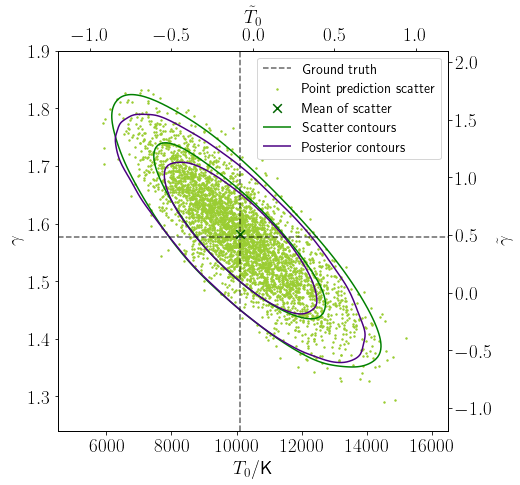

In [201]:
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

fig = plt.figure(figsize=(7, 7))
ax  = fig.subplots(1)

ax.axvline(T0_fid_upscaled, linestyle = '--', color = 'k', alpha = 0.6,)
ax.axhline(gamma_fid_upscaled, linestyle = '--', color = 'k', alpha = 0.6, label = 'Ground truth')

# ax.scatter(
#     fid_test_preds_best_network_transformed_upscaled[:N_sk_for_inference, 0],
#     fid_test_preds_best_network_transformed_upscaled[:N_sk_for_inference, 1],
#     color = 'yellowgreen', s = 2, 
#     label = 'Point prediction scatter',
# )

ax.scatter(
    mean_fid_test_pred_committee_transformed_upscaled[subset_sl, 0],
    mean_fid_test_pred_committee_transformed_upscaled[subset_sl, 1],
    color = 'yellowgreen', s = 2, 
    label = 'Point prediction scatter',
)

# ax.scatter(
#     *np.mean(fid_test_preds_best_network_transformed_upscaled[:N_sk_for_inference,:], axis = 0),
#     marker = 'x', color = 'darkgreen', s = 75,
#     label = 'Mean of scatter',
# )
ax.scatter(
    *np.mean(mean_fid_test_pred_committee_transformed_upscaled[subset_sl,:], axis = 0),
    marker = 'x', color = 'darkgreen', s = 75,
    label = 'Mean of scatter',
)
# cs = sb.kdeplot(
#     x = fid_test_preds_best_network_transformed_upscaled[:N_sk_for_inference, 0],
#     y = fid_test_preds_best_network_transformed_upscaled[:N_sk_for_inference, 1],
#     levels = [0.05, 0.32], ax = ax,
#     bw_adjust = 2,
#     label  = 'Scatter contours',
#     color  = 'green',
# )
# print(cs)
cs = sb.kdeplot(
    x = mean_fid_test_pred_committee_transformed_upscaled[subset_sl, 0],
    y = mean_fid_test_pred_committee_transformed_upscaled[subset_sl, 1],
    levels = [0.05, 0.32], ax = ax,
    bw_adjust = 2,
    label  = 'Scatter contours',
    color  = 'green',
)
# cg = sb.kdeplot(
#     x = gauss[:,0],
#     y = gauss[:,1],
#     levels = [0.05, 0.32], ax = ax,
#     bw_adjust = 2,
#     label  = 'Gaussian contours',
#     color  = 'darkorange',
# )
cp = sb.kdeplot(
    x = rsansa_flatchain_committee_fid_unscaled[:, 0],
    y = rsansa_flatchain_committee_fid_unscaled[:, 1],
    levels = [0.05, 0.32],
    bw_adjust = 2,
    label = 'Posterior contours',
    color = 'indigo',
    # linewidth = 1.0,
    # fill  = True,
    # alpha = 0.2,
)

x_lims = np.array([-1.2, 1.2])
y_lims = np.array([-1.2, 2.1])

ax_y = ax.twinx()
# ax_y.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_y.set_ylim(*y_lims)
ax_y.set_ylabel(r'$\tilde{\gamma}$')

ax_x = ax.twiny()
# ax_x.scatter(T0s_orthogrid, gammas_orthogrid, color = 'k', s = 9)
ax_x.set_xlim(*x_lims)
ax_x.set_xlabel(r'$\tilde{T}_0$');
# ax = plt.gca()
# ax.clabel(cs, [68, 95], inline = True, fmt = '%d\%', fontsize = 12)
# ax.clabel(cg, [68, 95], inline = True, fmt = '%d\%', fontsize = 12)
# plt.scatter(
#     T0s_orthogrid,
#     gammas_orthogrid,
#     s = 4, color = 'k', alpha = 0.5,
# )
ax.set_xlim(*rescale_T0(x_lims, mode = 'up'))
ax.set_ylim(*rescale_gamma(y_lims, mode = 'up'))
ax.set_xlabel(r'$T_0$/K')
ax.set_ylabel(r'$\gamma$')
ax.legend(loc = 'upper right', fontsize = 14);
plt.savefig(op_path+f'figures/scatter__and__posterior_contours_fiducial_tdr.pdf', bbox_inches = 'tight')

T0 =  10104.151919484138
gamma =  1.575970380306244


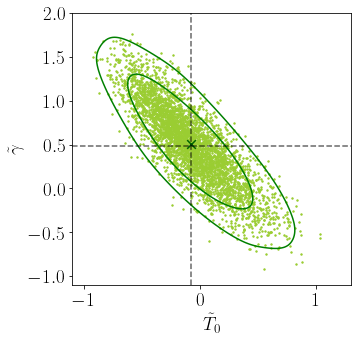

In [78]:
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

fig = plt.figure(figsize=(5, 5)) #(6.5, 6.5))
ax  = fig.subplots(1)

ax.axvline(T0_fid, linestyle = '--', color = 'k', alpha = 0.6, linewidth = 1.5,)
ax.axhline(gamma_fid, linestyle = '--', color = 'k', alpha = 0.6, linewidth = 1.5, label = 'Truth')
ax.scatter(
    fid_test_preds_best_network_transformed[:, 0],
    fid_test_preds_best_network_transformed[:, 1],
    color = 'yellowgreen', s = 2, 
    label = r'Point prediction scatter, \textsc{Sansa}',
)
mean = np.mean(fid_test_preds_best_network_transformed[:, :2], axis = 0)
# Cov  = np.cov( rsansa_transformed_point_predictions[tester_slice_rsansa].T)
# gauss = np.random.multivariate_normal(mean, Sigma_matrix_mean_rsansa, size = 10*N_skewers_each_test)

ax.scatter(
    mean[0], mean[1],
    marker = 'x', color = 'darkgreen', s = 75,
    label = 'Mean of scatter',
)
cs = sb.kdeplot(
    x = fid_test_preds_best_network_transformed[:, 0],
    y = fid_test_preds_best_network_transformed[:, 1],
    levels = [0.05, 0.32], ax = ax,
    bw_adjust = 2.0,
    label  = 'Scatter contours',
    color  = 'green',
    # linewidth = 1.5,
)
ax.set_ylim(-1.1, 2.0)
ax.set_xlim(-1.1, 1.3)
ax.set_xlabel(r'$\tilde{T}_0$')
ax.set_ylabel(r'$\tilde{\gamma}$');
# ax.legend(loc = 'upper right', fontsize = 14);
# plt.savefig(op_path+f'figures/scatter_cartoon.pdf', bbox_inches = 'tight')

## Inference with Sansa

### With the committee

In [45]:
# Fiducial model test case, committee

def compute_likelihood_rsansa_fid_committee(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_transformed, axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_fid_committee(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                  = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_fid = sampler_rsansa.flatchain[500000:,:]

In [46]:
# N_rSansa  = 1000
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fid_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fid_upscaled = rescale_chain(rsansa_flatchain_committee_fid_upscaled, mode = 'up')

rsansa_flatchain_committee_fid_upscaled[:,0] = rsansa_flatchain_committee_fid_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fid_upscaled[:,1] = rsansa_flatchain_committee_fid_upscaled[:,1] / gamma_fid_upscaled - 1

In [47]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fid_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fid_upscaled100 = rescale_chain(rsansa_flatchain_committee_fid_upscaled100, mode = 'up')

rsansa_flatchain_committee_fid_upscaled100[:,0] = rsansa_flatchain_committee_fid_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fid_upscaled100[:,1] = rsansa_flatchain_committee_fid_upscaled100[:,1] / gamma_fid_upscaled - 1

### With the best network

In [73]:
# Fiducial model test case, best network

def compute_likelihood_rsansa_fid_best(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = mean_fid_test_pred_best_transformed #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_fid_best(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa             = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_fid = sampler_rsansa.flatchain[500000:,:]

In [ ]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_fid_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_fid_upscaled = rescale_chain(rsansa_flatchain_best_fid_upscaled, mode = 'up')

rsansa_flatchain_best_fid_upscaled[:,0] = rsansa_flatchain_best_fid_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_fid_upscaled[:,1] = rsansa_flatchain_best_fid_upscaled[:,1] / gamma_fid_upscaled - 1

In [67]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_fid_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_fid_upscaled100 = rescale_chain(rsansa_flatchain_best_fid_upscaled100, mode = 'up')

rsansa_flatchain_best_fid_upscaled100[:,0] = rsansa_flatchain_best_fid_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_fid_upscaled100[:,1] = rsansa_flatchain_best_fid_upscaled100[:,1] / gamma_fid_upscaled - 1

### With the least well-performed network

In [68]:
# Fiducial model test case, last network

def compute_likelihood_rsansa_fid_last(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = mean_fid_test_pred_last_network_transformed #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_last(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_last(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_last[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_fid_last(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa             = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_last_fid = sampler_rsansa.flatchain[500000:,:]

In [69]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_last_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_last_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_last_fid_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_last_fid_upscaled = rescale_chain(rsansa_flatchain_last_fid_upscaled, mode = 'up')

rsansa_flatchain_last_fid_upscaled[:,0] = rsansa_flatchain_last_fid_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_last_fid_upscaled[:,1] = rsansa_flatchain_last_fid_upscaled[:,1] / gamma_fid_upscaled - 1

In [70]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_last_fid, axis = 0)
rsansa_deltachain         = rsansa_flatchain_last_fid - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_last_fid_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_last_fid_upscaled100 = rescale_chain(rsansa_flatchain_last_fid_upscaled100, mode = 'up')

rsansa_flatchain_last_fid_upscaled100[:,0] = rsansa_flatchain_last_fid_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_last_fid_upscaled100[:,1] = rsansa_flatchain_last_fid_upscaled100[:,1] / gamma_fid_upscaled - 1

In [73]:
mcmc_flatchain_upscaled_crosscorr    = np.load(f'kt_rSansa_Ext2/tuner_impl_2/mcmc_chains_for_comparison/mcmc_crosscorr_orthogrid{idx_of_inference_tester}_100LOS.npy')
mcmc_flatchain_upscaled_nocorr       = np.load(f'kt_rSansa_Ext2/tuner_impl_2/mcmc_chains_for_comparison/mcmc_nocorr_orthogrid{idx_of_inference_tester}_100LOS.npy')
mcmc_flatchain_upscaled_ps1d         = np.load(f'kt_rSansa_Ext2/tuner_impl_2/mcmc_chains_for_comparison/mcmc_ps1d_orthogrid{idx_of_inference_tester}_100LOS.npy')
mcmc_flatchain_upscaled_fpdf         = np.load(f'kt_rSansa_Ext2/tuner_impl_2/mcmc_chains_for_comparison/mcmc_fpdf_orthogrid{idx_of_inference_tester}_100LOS.npy')
# mcmc_flatchain_offgrid_upscaled_ps1d = np.load(f'mcmc_chains/mcmc_flatchain_upscaled_ps1d_offgrid_{idx_of_inference_tester_offgrid}_100LOS.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'kt_rSansa_Ext2/tuner_impl_2/mcmc_chains_for_comparison/mcmc_crosscorr_orthogrid120_100LOS.npy'

### Loading conventional summary MCMC chains for comparison

In [48]:
N_MCMC = 100
mcmc_flatchain_upscaled_crosscorr100 = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS.npy')
mcmc_flatchain_upscaled_ps1d100      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS.npy')

In [49]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS.npy')
mcmc_flatchain_upscaled_ps1d      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS.npy')

In [50]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr_1k = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS_1000sk.npy')
mcmc_flatchain_upscaled_ps1d_1k      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS_1000sk.npy')

In [51]:
N_MCMC = 1000
mcmc_flatchain_upscaled_crosscorr_1k_fullcov = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_crosscorr_fiducial_tdr_{N_MCMC}LOS_1000sk_fullcov.npy')
mcmc_flatchain_upscaled_ps1d_1k_fullcov      = np.load(op_path+f'mcmc_chains_for_comparison/mcmc_ps1d_fiducial_tdr_{N_MCMC}LOS_1000sk_fullcov.npy')

In [160]:
N_MCMC_target = 1000
#mcmc_flatchain.shape
means_mcmc_flatchain    = np.mean(mcmc_flatchain_upscaled_crosscorr, axis = 0)
mcmc_deltachain         = mcmc_flatchain_upscaled_crosscorr - means_mcmc_flatchain
mcmc_deltachain        *= np.sqrt(N_MCMC/N_MCMC_target)  ## Here the actual rescaling of the contours to match a certain N_los (that is in the denominator in sqrt) happens! 
mcmc_flatchain_upscaled_crosscorr = mcmc_deltachain + means_mcmc_flatchain

means_mcmc_flatchain    = np.mean(mcmc_flatchain_upscaled_ps1d, axis = 0)
mcmc_deltachain         = mcmc_flatchain_upscaled_ps1d - means_mcmc_flatchain
mcmc_deltachain        *= np.sqrt(N_MCMC/N_MCMC_target)  ## Here the actual rescaling of the contours to match a certain N_los (that is in the denominator in sqrt) happens! 
mcmc_flatchain_upscaled_ps1d = mcmc_deltachain + means_mcmc_flatchain

### Plotting the posterior contours

T0 =  10104.151919484138
gamma =  1.575970380306244


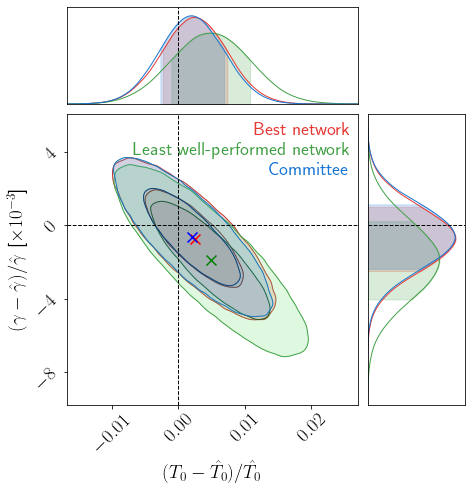

In [81]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()

# c.add_chain(
#     rSansa_posterior_distribution,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'ICV Posterior',
# )

# c.add_chain(
#     mcmc_flatchain_upscaled_ps1d,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = '$P_F(k)$ only',
# )
# # c.add_chain(
# #     mcmc_flatchain_upscaled_fpdf,
# #     parameters = [rel_T0_string, rel_gamma_string],
# #     name = 'FPDF only',
# # )
# c.add_chain(
#     mcmc_flatchain_upscaled_crosscorr,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Joint, $P_F(k)$ \& PDF',
# )
# c.add_chain(
#     mcmc_flatchain_upscaled_nocorr,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = '$P(k)$ \& FPDF, no corr.',
# )


# c.add_chain(
#     rSansa_posterior_distribution_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior',
# )
# c.add_chain(
#     rsansa_flatchain_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Best model',
# )

# c.add_chain(
#     rsansa_flatchain_committee_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Committee',
# )
c.add_chain(
    rsansa_flatchain_best_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Best network',
)
c.add_chain(
    rsansa_flatchain_last_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Least well-performed network',
)
c.add_chain(
    rsansa_flatchain_committee_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Committee',
)
# c.add_chain(
#     rSansa_posterior_distribution_rolled_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior, rolled',
# )
# c.add_chain(
#     rsansa_flatchain_best_rolled128_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_best_rolled_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )

# c.add_chain(
#     rSansa_posterior_distribution_flipped_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior, flipped',
# )
# c.add_chain(
#     rsansa_flatchain_best_flipped_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )

# c.add_chain(
#     rsansa_flatchain_offgrid_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Off-grid',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    # bar_shade   = [True, False, False, False, True],
    shade_alpha = 0.2, #[0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
ax.scatter(
    *np.mean(rsansa_flatchain_best_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'r', marker = 'x', label = "Best network mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_last_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'g', marker = 'x', label = "Last network mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'b', marker = 'x', label = "Committee mean", #zorder = 0, 
)
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_rolled_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_flipped_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'indigo', marker = 'x', label = "Flipped mean", #zorder = 0, 
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', marker = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_tdr_best_vs_committee_4k.pdf', bbox_inches = 'tight')

In [140]:
def chi2(chain, truth):
    Cov = np.cov(chain.T)
    inv_Cov = np.linalg.inv(Cov)
    # print(Cov.shape)
    c2 = 0
    for i in range(len(chain)):
        c2 += (chain[i] - truth).dot(inv_Cov.dot((chain[i] - truth).T))
    return c2/len(chain) #(chain-truth).dot(Cov.dot((chain-truth).T))

In [141]:
truth = np.array([T0_fid_upscaled, gamma_fid_upscaled])
chi2_committee = chi2((rsansa_flatchain_committee_fid_upscaled + 1.)*truth, truth)
chi2_bestnet   = chi2((rsansa_flatchain_best_fid_upscaled + 1.)*truth, truth)

In [142]:
print("Committee:\t", chi2_committee)
print("Best network:\t", chi2_bestnet)

Committee:	 2.194187153107949
Best network:	 2.255348903881974


T0 =  10104.151919484138
gamma =  1.575970380306244


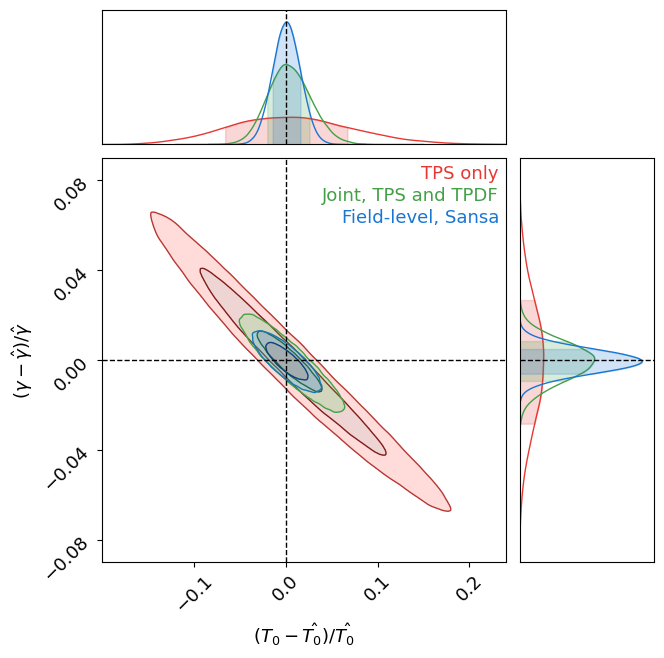

In [53]:
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

c   = ChainConsumer()

# c.add_chain(
#     rsansa_flatchain_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Best model',
# )
c.add_chain(
    mcmc_flatchain_upscaled_ps1d100, #_1k_fullcov,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'TPS only', #'TPS only',
)
c.add_chain(
    mcmc_flatchain_upscaled_crosscorr100, #_1k_fullcov,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Joint, TPS and TPDF', #'Joint, TPS \& TPDF',
)
c.add_chain(
    rsansa_flatchain_committee_fid_upscaled100,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Field-level, Sansa', #r'Field-level, \textsc{Sansa}',
)

c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 13, #19,
    label_font_size = 13, #19,
    # bar_shade   = [False, True, True, False, True],
    shade_alpha = 0.2, #[0.0, 0.2, 0.2, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    extents = [(-0.2,0.24),(-0.09, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
# ax.scatter(
#     rescale_T0(mean_fid_test_pred_best_network_transformed[0], mode = 'up')/T0_fid_upscaled - 1, 
#     rescale_gamma(mean_fid_test_pred_best_network_transformed[1], mode = 'up')/gamma_fid_upscaled - 1, 
#     s = 100, color = 'r', marker = 'x', label = "Fiducial mean", #zorder = 0, 
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_rolled128[idx_of_inference_tester,0], mode = 'up')/T0s_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     rescale_gamma(mean_preds_rsansa_rolled128[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'g', zorder = 0, marker = 'x', label = "Rolled mean",
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_rolled[idx_of_inference_tester,0], mode = 'up')/T0s_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     rescale_gamma(mean_preds_rsansa_rolled[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'dodgerblue', zorder = 0, marker = 'x', label = "Rolled mean",
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_flipped[idx_of_inference_tester,0], mode = 'up')/T0s_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     rescale_gamma(mean_preds_rsansa_flipped[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'indigo', zorder = 0, marker = 'x', label = "Flipped mean",
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', marker = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_with_summaries_crosscorr_presentation_version.pdf', bbox_inches = 'tight')

In [116]:
detC_ps1d   = np.linalg.det(np.cov(mcmc_flatchain_upscaled_ps1d100.T))
# detC_nocorr = np.linalg.det(np.cov(mcmc_flatchain_upscaled_nocorr.T))
detC_corr   = np.linalg.det(np.cov(mcmc_flatchain_upscaled_crosscorr100.T))
detC_rsansa_best      = np.linalg.det(np.cov(rsansa_flatchain_best_fid_upscaled100.T))
detC_rsansa_committee = np.linalg.det(np.cov(rsansa_flatchain_committee_fid_upscaled100.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_flatchain_upscaled.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_preds.T)/100)
# print(detC_ps1d)
# print(detC_corr)
# print(detC_rsansa_best)
# print(detC_ps1d/detC_rsansa)
# print(detC_corr/detC_rsansa)

print(np.sqrt(detC_ps1d/detC_rsansa_best))
print(np.sqrt(detC_corr/detC_rsansa_best))
print('\n')
print(np.sqrt(detC_ps1d/detC_rsansa_committee))
print(np.sqrt(detC_corr/detC_rsansa_committee))
print('\n')
print(np.sqrt(detC_rsansa_best/detC_rsansa_committee))

5.3669587835309605
1.6241886422213334


5.650429033010263
1.7099744993858683


1.052817668425023


In [226]:
detC_rsansa_best      = np.linalg.det(np.cov(rsansa_flatchain_best_fid_upscaled.T))
detC_rsansa_committee = np.linalg.det(np.cov(rsansa_flatchain_committee_fid_upscaled.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_flatchain_upscaled.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_preds.T)/100)
# print(detC_ps1d)
# print(detC_corr)
# print(detC_rsansa_best)
# print(detC_ps1d/detC_rsansa)
# print(detC_corr/detC_rsansa)

print(100*(np.sqrt(detC_rsansa_best/detC_rsansa_committee) - 1))

5.584002802391552


## Test with a different extraction direction of the skewers

In [229]:
fidfilename = '/project/ls-gruen/users/parth.nayak/lya_synthesis_data/fiducial_tdr_models/extracted_lya_abs_profiles_redshift_2.2_grid1_01722_S5678_cutoff_doppler.h5'
N_sk_to_pick = 2*N_skewers_each_test
y_test_spectra = np.zeros((N_sk_to_pick, 512+5, 1), dtype = 'float32')
with h5py.File(fidfilename, 'r') as f:
    A_y_1  = f['A_tau_rescaling/A_y_1'][0]
    F_sk   = np.exp( -A_y_1 * f['tau'][100000:100000+N_sk_to_pick, :])
    k_full = f['k_in_skminv'][:]
    T0, gamma = f['tdr_params'][:]
T0    = rescale_T0(T0)
gamma = rescale_gamma(gamma)
F_sk  = discard_large_k_modes_and_smooth(F_sk, k_full)
F_sk  = np.mean(F_sk.reshape((-1, 512, 8)), axis = -1)
y_test_spectra[:, :512, 0]    = F_sk
y_test_spectra[:, 512:514, 0] = T0, gamma

y_test_spectra.shape

(8000, 517, 1)

In [230]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_y = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_y.append(rsansa.predict(y_test_spectra[:, :512, :]))
fid_test_preds_committee_y = np.array(fid_test_preds_committee_y)
print(fid_test_preds_committee_y.shape)

fid_test_preds_best_y = fid_test_preds_committee_y[best_network_idx]
print(fid_test_preds_best_y.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [231]:
fid_test_preds_committee_y_transformed = np.zeros((*fid_test_preds_committee_y.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_y_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_y[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_y[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_y_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_y[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_y[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_y_transformed.shape

(10, 8000, 2)

In [232]:
fid_test_preds_best_y_transformed = fid_test_preds_committee_y_transformed[best_network_idx]
fid_test_preds_best_y_transformed_upscaled = rescale_chain(fid_test_preds_best_y_transformed, mode = 'up')
fid_test_preds_best_y_transformed_upscaled.shape

(8000, 2)

In [233]:
test_subset_idx = 0
subset_sl = np.s_[test_subset_idx*N_sk_for_inference : (test_subset_idx+1)*N_sk_for_inference]

In [234]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
y_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
y_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_y[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_y[i, subset_sl, 3])
    c3s = fid_test_preds_committee_y[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    y_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    y_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
y_test_committee_transformed_network_covariance_matrices.shape, y_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [235]:
mean_fid_test_pred_committee_y_transformed = np.average(fid_test_preds_committee_y_transformed, axis = 0, weights = 1./y_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_y_transformed.shape

(8000, 2)

In [236]:
mean_fid_test_pred_committee_y_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_y_transformed, mode = 'up') 
mean_fid_test_pred_committee_y_transformed_upscaled.shape

(8000, 2)

In [237]:
# Fiducial model, Rolled-r test case, committee

def compute_likelihood_rsansa_committee_y(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_y_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_y(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_y     = sampler_rsansa.flatchain[500000:,:]

In [238]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_y, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_y - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_y_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_y_upscaled100 = rescale_chain(rsansa_flatchain_committee_y_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_y_upscaled100[:,0] = rsansa_flatchain_committee_y_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_y_upscaled100[:,1] = rsansa_flatchain_committee_y_upscaled100[:,1] / gamma_fid_upscaled - 1

In [239]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_y, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_y - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_y_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_y_upscaled = rescale_chain(rsansa_flatchain_committee_y_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_y_upscaled[:,0] = rsansa_flatchain_committee_y_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_y_upscaled[:,1] = rsansa_flatchain_committee_y_upscaled[:,1] / gamma_fid_upscaled - 1

In [89]:
# Fiducial model, Rolled-r test case, best network

def compute_likelihood_rsansa_best_rolled(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_rolled_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_rolled(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_rolled = sampler_rsansa.flatchain[500000:,:]

In [90]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled100 = rescale_chain(rsansa_flatchain_best_rolled_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled100[:,0] = rsansa_flatchain_best_rolled_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled100[:,1] = rsansa_flatchain_best_rolled_upscaled100[:,1] / gamma_fid_upscaled - 1

In [91]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled = rescale_chain(rsansa_flatchain_best_rolled_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled[:,0] = rsansa_flatchain_best_rolled_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled[:,1] = rsansa_flatchain_best_rolled_upscaled[:,1] / gamma_fid_upscaled - 1

## Augmenting test data

In [99]:
fid_test_spectra_rolled    = roll_spectral_dataset(fid_test_spectra, N_roll = 256) #
fid_test_spectra_rolled128 = roll_spectral_dataset(fid_test_spectra, N_roll = 128) # 128
fid_test_spectra_flipped   = flip_spectral_dataset(fid_test_spectra)

fid_test_spectra_rolled.shape, fid_test_spectra_rolled128.shape, fid_test_spectra_flipped.shape

((8000, 517, 1), (8000, 517, 1), (8000, 517, 1))

In [201]:
def roll_spectral_dataset_randomly(spectral_dataset, N_pix_spectrum = 512, seed = 100): # spectral_dataset needs to be in lyanna dataset format
    new_set = np.copy(spectral_dataset)
    np.random.seed(seed)
    N_roll_arr = np.random.randint(0, N_pix_spectrum, spectral_dataset.shape[0])
    for i in range(spectral_dataset.shape[0]):
        new_set[i, :N_pix_spectrum] = np.roll(spectral_dataset[i,:N_pix_spectrum], N_roll_arr[i], axis = 0)
    return new_set

In [202]:
fid_test_spectra_rr    = roll_spectral_dataset_randomly(fid_test_spectra, seed = 1)
fid_test_spectra_rr.shape

(8000, 517, 1)

In [214]:
def flip_spectral_dataset(spectral_dataset, N_pix_spectrum = 512, randomly = False, seed = 100, p = 0.1):
    new_set = np.copy(spectral_dataset)
    if randomly:
        np.random.seed(seed)
        # yesno = 2*np.random.randint(0, 2, spectral_dataset.shape[0]) - 1
        yesno = np.random.choice(np.array([-1,1]), size = spectral_dataset.shape[0], p = np.array([p, 1-p]))
        for i in range(spectral_dataset.shape[0]):
            new_set[i, :N_pix_spectrum] = spectral_dataset[i,:N_pix_spectrum][::yesno[i],:]
    else:
        new_set[:, :N_pix_spectrum] = spectral_dataset[:,:N_pix_spectrum][:,::-1,:]
    return new_set

In [215]:
fid_test_spectra_fr    = flip_spectral_dataset(fid_test_spectra, randomly = True, seed = 100)
fid_test_spectra_fr.shape

(8000, 517, 1)

### Rolled-s case

In [82]:
# with tf.device(f'/device:GPU:{GPU_id}'):
metrics_rolled = rsansa.evaluate(fid_test_spectra_rolled[:, :512, :], fid_test_spectra_rolled[:, 512:, 0])
# metrics

125/125 [==============================] - 4s 3ms/step - loss: -3.5486 - ChiSquaredError: 1.8985 - MeanSquaredError: 0.1834 - LogDeterminantSigma: -5.4471


In [100]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_rolled = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_rolled.append(rsansa.predict(fid_test_spectra_rolled[:, :512, :]))
fid_test_preds_committee_rolled = np.array(fid_test_preds_committee_rolled)
print(fid_test_preds_committee_rolled.shape)

fid_test_preds_best_rolled = fid_test_preds_committee_rolled[best_network_idx]
print(fid_test_preds_best_rolled.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [101]:
fid_test_preds_committee_rolled_transformed = np.zeros((*fid_test_preds_committee_rolled.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_rolled_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_rolled[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_rolled[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_rolled_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_rolled[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_rolled[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_rolled_transformed.shape

(10, 8000, 2)

In [102]:
fid_test_preds_best_rolled_transformed = fid_test_preds_committee_rolled_transformed[best_network_idx]
fid_test_preds_best_rolled_transformed_upscaled = rescale_chain(fid_test_preds_best_rolled_transformed, mode = 'up')
fid_test_preds_best_rolled_transformed_upscaled.shape

(8000, 2)

In [104]:
test_subset_idx = 0
subset_sl = np.s_[test_subset_idx*N_sk_for_inference : (test_subset_idx+1)*N_sk_for_inference]

In [105]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
rolled_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
rolled_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_rolled[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_rolled[i, subset_sl, 3])
    c3s = fid_test_preds_committee_rolled[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    rolled_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    rolled_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
rolled_test_committee_transformed_network_covariance_matrices.shape, rolled_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [106]:
mean_fid_test_pred_committee_rolled_transformed = np.average(fid_test_preds_committee_rolled_transformed, axis = 0, weights = 1./rolled_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_rolled_transformed.shape

(8000, 2)

In [107]:
mean_fid_test_pred_committee_rolled_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_rolled_transformed, mode = 'up') 
mean_fid_test_pred_committee_rolled_transformed_upscaled.shape

(8000, 2)

In [108]:
# Fiducial model, Rolled-s test case, committee

def compute_likelihood_rsansa_committee_rolled(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_rolled_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_rolled(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_rolled = sampler_rsansa.flatchain[500000:,:]

In [109]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rolled_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rolled_upscaled100 = rescale_chain(rsansa_flatchain_committee_rolled_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rolled_upscaled100[:,0] = rsansa_flatchain_committee_rolled_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rolled_upscaled100[:,1] = rsansa_flatchain_committee_rolled_upscaled100[:,1] / gamma_fid_upscaled - 1

In [110]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rolled_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rolled_upscaled = rescale_chain(rsansa_flatchain_committee_rolled_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rolled_upscaled[:,0] = rsansa_flatchain_committee_rolled_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rolled_upscaled[:,1] = rsansa_flatchain_committee_rolled_upscaled[:,1] / gamma_fid_upscaled - 1

In [89]:
# Fiducial model, Rolled-s test case, best network

def compute_likelihood_rsansa_best_rolled(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_rolled_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_rolled(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_rolled = sampler_rsansa.flatchain[500000:,:]

In [90]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled100 = rescale_chain(rsansa_flatchain_best_rolled_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled100[:,0] = rsansa_flatchain_best_rolled_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled100[:,1] = rsansa_flatchain_best_rolled_upscaled100[:,1] / gamma_fid_upscaled - 1

In [91]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled = rescale_chain(rsansa_flatchain_best_rolled_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled[:,0] = rsansa_flatchain_best_rolled_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled[:,1] = rsansa_flatchain_best_rolled_upscaled[:,1] / gamma_fid_upscaled - 1

### Rolled-r case

In [82]:
# with tf.device(f'/device:GPU:{GPU_id}'):
metrics_rolled = rsansa.evaluate(fid_test_spectra_rolled[:, :512, :], fid_test_spectra_rolled[:, 512:, 0])
# metrics

125/125 [==============================] - 4s 3ms/step - loss: -3.5486 - ChiSquaredError: 1.8985 - MeanSquaredError: 0.1834 - LogDeterminantSigma: -5.4471


In [203]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_rr = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_rr.append(rsansa.predict(fid_test_spectra_rr[:, :512, :]))
fid_test_preds_committee_rr = np.array(fid_test_preds_committee_rr)
print(fid_test_preds_committee_rr.shape)

fid_test_preds_best_rr = fid_test_preds_committee_rr[best_network_idx]
print(fid_test_preds_best_rr.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [204]:
fid_test_preds_committee_rr_transformed = np.zeros((*fid_test_preds_committee_rr.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_rr_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_rr[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_rr[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_rr_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_rr[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_rr[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_rr_transformed.shape

(10, 8000, 2)

In [205]:
fid_test_preds_best_rr_transformed = fid_test_preds_committee_rr_transformed[best_network_idx]
fid_test_preds_best_rr_transformed_upscaled = rescale_chain(fid_test_preds_best_rr_transformed, mode = 'up')
fid_test_preds_best_rr_transformed_upscaled.shape

(8000, 2)

In [206]:
test_subset_idx = 0
subset_sl = np.s_[test_subset_idx*N_sk_for_inference : (test_subset_idx+1)*N_sk_for_inference]

In [207]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
rr_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
rr_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_rr[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_rr[i, subset_sl, 3])
    c3s = fid_test_preds_committee_rr[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    rr_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    rr_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
rr_test_committee_transformed_network_covariance_matrices.shape, rr_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [208]:
mean_fid_test_pred_committee_rr_transformed = np.average(fid_test_preds_committee_rr_transformed, axis = 0, weights = 1./rr_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_rr_transformed.shape

(8000, 2)

In [209]:
mean_fid_test_pred_committee_rr_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_rr_transformed, mode = 'up') 
mean_fid_test_pred_committee_rr_transformed_upscaled.shape

(8000, 2)

In [210]:
# Fiducial model, Rolled-r test case, committee

def compute_likelihood_rsansa_committee_rr(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_rr_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_rr(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_rr     = sampler_rsansa.flatchain[500000:,:]

In [211]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rr, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rr - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rr_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rr_upscaled100 = rescale_chain(rsansa_flatchain_committee_rr_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rr_upscaled100[:,0] = rsansa_flatchain_committee_rr_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rr_upscaled100[:,1] = rsansa_flatchain_committee_rr_upscaled100[:,1] / gamma_fid_upscaled - 1

In [212]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rr, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rr - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rr_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rr_upscaled = rescale_chain(rsansa_flatchain_committee_rr_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rr_upscaled[:,0] = rsansa_flatchain_committee_rr_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rr_upscaled[:,1] = rsansa_flatchain_committee_rr_upscaled[:,1] / gamma_fid_upscaled - 1

In [89]:
# Fiducial model, Rolled-r test case, best network

def compute_likelihood_rsansa_best_rolled(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_rolled_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_rolled(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_rolled = sampler_rsansa.flatchain[500000:,:]

In [90]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled100 = rescale_chain(rsansa_flatchain_best_rolled_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled100[:,0] = rsansa_flatchain_best_rolled_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled100[:,1] = rsansa_flatchain_best_rolled_upscaled100[:,1] / gamma_fid_upscaled - 1

In [91]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled_upscaled = rescale_chain(rsansa_flatchain_best_rolled_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled_upscaled[:,0] = rsansa_flatchain_best_rolled_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled_upscaled[:,1] = rsansa_flatchain_best_rolled_upscaled[:,1] / gamma_fid_upscaled - 1

### Rolled-q case

In [92]:
# with tf.device(f'/device:GPU:{GPU_id}'):
metrics_rolled128 = rsansa.evaluate(fid_test_spectra_rolled128[:, :512, :], fid_test_spectra_rolled128[:, 512:, 0])
# metrics

125/125 [==============================] - 4s 3ms/step - loss: -3.4334 - ChiSquaredError: 1.7926 - MeanSquaredError: 0.2065 - LogDeterminantSigma: -5.2261


In [111]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_rolled128 = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_rolled128.append(rsansa.predict(fid_test_spectra_rolled128[:, :512, :]))
fid_test_preds_committee_rolled128 = np.array(fid_test_preds_committee_rolled128)
print(fid_test_preds_committee_rolled128.shape)

fid_test_preds_best_rolled128 = fid_test_preds_committee_rolled128[best_network_idx]
print(fid_test_preds_best_rolled128.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [112]:
fid_test_preds_committee_rolled128_transformed = np.zeros((*fid_test_preds_committee_rolled128.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_rolled128_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_rolled128[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_rolled128[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_rolled128_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_rolled128[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_rolled128[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_rolled128_transformed.shape

(10, 8000, 2)

In [113]:
fid_test_preds_best_rolled128_transformed = fid_test_preds_committee_rolled128_transformed[best_network_idx]

In [114]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
rolled128_test_committee_transformed_network_covariance_matrices = np.zeros((N_members_committee,2,2))
rolled128_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_rolled128[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_rolled128[i, subset_sl, 3])
    c3s = fid_test_preds_committee_rolled128[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    rolled128_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    rolled128_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
rolled128_test_committee_transformed_network_covariance_matrices.shape, rolled128_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [115]:
mean_fid_test_pred_committee_rolled128_transformed = np.average(fid_test_preds_committee_rolled128_transformed, axis = 0, weights = 1./rolled128_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_rolled128_transformed.shape

(8000, 2)

In [116]:
mean_fid_test_pred_committee_rolled128_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_rolled128_transformed, mode = 'up') 
mean_fid_test_pred_committee_rolled128_transformed_upscaled.shape

(8000, 2)

In [117]:
# Fiducial model, Rolled-q test case, committee

def compute_likelihood_rsansa_committee_rolled128(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_rolled128_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_rolled128(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_rolled128 = sampler_rsansa.flatchain[500000:,:]

In [118]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rolled128, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rolled128 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rolled128_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rolled128_upscaled100 = rescale_chain(rsansa_flatchain_committee_rolled128_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rolled128_upscaled100[:,0] = rsansa_flatchain_committee_rolled128_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rolled128_upscaled100[:,1] = rsansa_flatchain_committee_rolled128_upscaled100[:,1] / gamma_fid_upscaled - 1

In [119]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_rolled128, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_rolled128 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_rolled128_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_rolled128_upscaled = rescale_chain(rsansa_flatchain_committee_rolled128_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_rolled128_upscaled[:,0] = rsansa_flatchain_committee_rolled128_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_rolled128_upscaled[:,1] = rsansa_flatchain_committee_rolled128_upscaled[:,1] / gamma_fid_upscaled - 1

In [102]:
# Fiducial model, Rolled-q test case, best network

def compute_likelihood_rsansa_best_rolled128(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_rolled128_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_rolled128(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_rolled128 = sampler_rsansa.flatchain[500000:,:]

In [103]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled128, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled128 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled128_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled128_upscaled100 = rescale_chain(rsansa_flatchain_best_rolled128_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled128_upscaled100[:,0] = rsansa_flatchain_best_rolled128_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled128_upscaled100[:,1] = rsansa_flatchain_best_rolled128_upscaled100[:,1] / gamma_fid_upscaled - 1

In [104]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_rolled128, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_rolled128 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_rolled128_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_rolled128_upscaled = rescale_chain(rsansa_flatchain_best_rolled128_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_rolled128_upscaled[:,0] = rsansa_flatchain_best_rolled128_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_rolled128_upscaled[:,1] = rsansa_flatchain_best_rolled128_upscaled[:,1] / gamma_fid_upscaled - 1

### Flipped case

In [84]:
# with tf.device(f'/device:GPU:{GPU_id}'):
metrics_flipped = rsansa.evaluate(fid_test_spectra_flipped[:, :512, :], fid_test_spectra_flipped[:, 512:, 0])
# metrics

125/125 [==============================] - 1s 3ms/step - loss: -3.4887 - ChiSquaredError: 1.9727 - MeanSquaredError: 0.1918 - LogDeterminantSigma: -5.4615


In [120]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_flipped = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_flipped.append(rsansa.predict(fid_test_spectra_flipped[:, :512, :]))
fid_test_preds_committee_flipped = np.array(fid_test_preds_committee_flipped)
print(fid_test_preds_committee_flipped.shape)

fid_test_preds_best_flipped = fid_test_preds_committee_flipped[best_network_idx]
print(fid_test_preds_best_flipped.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [121]:
fid_test_preds_committee_flipped_transformed = np.zeros((*fid_test_preds_committee_flipped.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_flipped_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_flipped[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_flipped[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_flipped_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_flipped[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_flipped[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_flipped_transformed.shape

(10, 8000, 2)

In [122]:
fid_test_preds_best_flipped_transformed = fid_test_preds_committee_flipped_transformed[best_network_idx]

In [123]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
flipped_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
flipped_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_flipped[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_flipped[i, subset_sl, 3])
    c3s = fid_test_preds_committee_flipped[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    flipped_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    flipped_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
flipped_test_committee_transformed_network_covariance_matrices.shape, flipped_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [124]:
mean_fid_test_pred_committee_flipped_transformed = np.average(fid_test_preds_committee_flipped_transformed, axis = 0, weights = 1./flipped_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_flipped_transformed.shape

(8000, 2)

In [125]:
mean_fid_test_pred_committee_flipped_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_flipped_transformed, mode = 'up') 
mean_fid_test_pred_committee_flipped_transformed_upscaled.shape

(8000, 2)

In [126]:
# Fiducial model, Flipped test case, committee

def compute_likelihood_rsansa_committee_flipped(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_flipped_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_flipped(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_flipped = sampler_rsansa.flatchain[500000:,:]

In [127]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_flipped_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_flipped_upscaled100 = rescale_chain(rsansa_flatchain_committee_flipped_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_flipped_upscaled100[:,0] = rsansa_flatchain_committee_flipped_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_flipped_upscaled100[:,1] = rsansa_flatchain_committee_flipped_upscaled100[:,1] / gamma_fid_upscaled - 1

In [128]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_flipped_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_flipped_upscaled = rescale_chain(rsansa_flatchain_committee_flipped_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_flipped_upscaled[:,0] = rsansa_flatchain_committee_flipped_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_flipped_upscaled[:,1] = rsansa_flatchain_committee_flipped_upscaled[:,1] / gamma_fid_upscaled - 1

In [114]:
# Fiducial model, Flipped test case, best network

def compute_likelihood_rsansa_best_flipped(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_flipped_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_flipped(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_flipped = sampler_rsansa.flatchain[500000:,:]

In [115]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_flipped_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_flipped_upscaled100 = rescale_chain(rsansa_flatchain_best_flipped_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_flipped_upscaled100[:,0] = rsansa_flatchain_best_flipped_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_flipped_upscaled100[:,1] = rsansa_flatchain_best_flipped_upscaled100[:,1] / gamma_fid_upscaled - 1

In [116]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_flipped_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_flipped_upscaled = rescale_chain(rsansa_flatchain_best_flipped_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_flipped_upscaled[:,0] = rsansa_flatchain_best_flipped_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_flipped_upscaled[:,1] = rsansa_flatchain_best_flipped_upscaled[:,1] / gamma_fid_upscaled - 1

### Flipped-r case

In [84]:
# with tf.device(f'/device:GPU:{GPU_id}'):
metrics_flipped = rsansa.evaluate(fid_test_spectra_flipped[:, :512, :], fid_test_spectra_flipped[:, 512:, 0])
# metrics

125/125 [==============================] - 1s 3ms/step - loss: -3.4887 - ChiSquaredError: 1.9727 - MeanSquaredError: 0.1918 - LogDeterminantSigma: -5.4615


In [216]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_fr = []
for i in range(N_members_committee):
    print(f"Predicting from run {i+1} of {N_members_committee}", end = '\r')
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_fr.append(rsansa.predict(fid_test_spectra_fr[:, :512, :]))
fid_test_preds_committee_fr = np.array(fid_test_preds_committee_fr)
print(fid_test_preds_committee_fr.shape)

fid_test_preds_best_fr = fid_test_preds_committee_fr[best_network_idx]
print(fid_test_preds_best_fr.shape)

(10, 8000, 5)om run 10 of 10
(8000, 5)


In [217]:
fid_test_preds_committee_fr_transformed = np.zeros((*fid_test_preds_committee_fr.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_fr_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_fr[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_fr[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_fr_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_fr[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_fr[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_fr_transformed.shape

(10, 8000, 2)

In [218]:
fid_test_preds_best_fr_transformed = fid_test_preds_committee_fr_transformed[best_network_idx]

In [219]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
fr_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
fr_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(fid_test_preds_committee_fr[i, subset_sl, 2])
    c2s = np.exp(fid_test_preds_committee_fr[i, subset_sl, 3])
    c3s = fid_test_preds_committee_fr[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    fr_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    fr_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
fr_test_committee_transformed_network_covariance_matrices.shape, fr_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [220]:
mean_fid_test_pred_committee_fr_transformed = np.average(fid_test_preds_committee_fr_transformed, axis = 0, weights = 1./fr_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_fid_test_pred_committee_fr_transformed.shape

(8000, 2)

In [221]:
mean_fid_test_pred_committee_fr_transformed_upscaled = rescale_chain(mean_fid_test_pred_committee_fr_transformed, mode = 'up') 
mean_fid_test_pred_committee_fr_transformed_upscaled.shape

(8000, 2)

In [222]:
# Fiducial model, Flipped-r test case, committee

def compute_likelihood_rsansa_committee_fr(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_fid_test_pred_committee_fr_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_fr(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_fr     = sampler_rsansa.flatchain[500000:,:]

In [223]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fr, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fr - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fr_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fr_upscaled100 = rescale_chain(rsansa_flatchain_committee_fr_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_fr_upscaled100[:,0] = rsansa_flatchain_committee_fr_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fr_upscaled100[:,1] = rsansa_flatchain_committee_fr_upscaled100[:,1] / gamma_fid_upscaled - 1

In [224]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_fr, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_fr - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_fr_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_fr_upscaled = rescale_chain(rsansa_flatchain_committee_fr_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_fr_upscaled[:,0] = rsansa_flatchain_committee_fr_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_committee_fr_upscaled[:,1] = rsansa_flatchain_committee_fr_upscaled[:,1] / gamma_fid_upscaled - 1

In [114]:
# Fiducial model, Flipped test case, best network

def compute_likelihood_rsansa_best_flipped(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(fid_test_preds_best_flipped_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_best(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_best(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_best[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_best_flipped(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa                     = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_best_flipped = sampler_rsansa.flatchain[500000:,:]

In [115]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/100) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_flipped_upscaled100 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_flipped_upscaled100 = rescale_chain(rsansa_flatchain_best_flipped_upscaled100, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_flipped_upscaled100[:,0] = rsansa_flatchain_best_flipped_upscaled100[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_flipped_upscaled100[:,1] = rsansa_flatchain_best_flipped_upscaled100[:,1] / gamma_fid_upscaled - 1

In [116]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_best_flipped, axis = 0)
rsansa_deltachain         = rsansa_flatchain_best_flipped - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1000) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_best_flipped_upscaled = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_best_flipped_upscaled = rescale_chain(rsansa_flatchain_best_flipped_upscaled, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_best_flipped_upscaled[:,0] = rsansa_flatchain_best_flipped_upscaled[:,0] / T0_fid_upscaled - 1
rsansa_flatchain_best_flipped_upscaled[:,1] = rsansa_flatchain_best_flipped_upscaled[:,1] / gamma_fid_upscaled - 1

### Plotting the posterior distributions

T0 =  10104.151919484138
gamma =  1.575970380306244


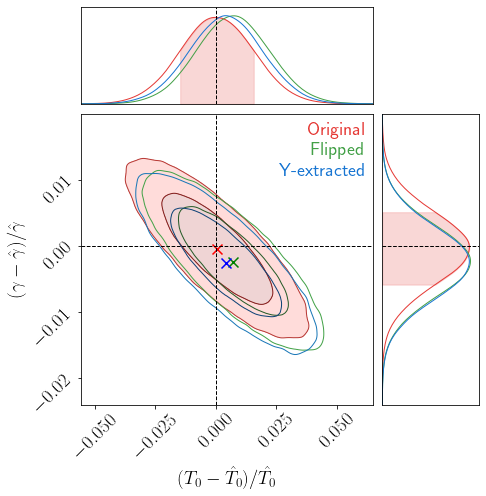

In [240]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()


c.add_chain(
    rsansa_flatchain_committee_fid_upscaled100,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Original',
)
# c.add_chain(
#     rsansa_flatchain_committee_rolled128_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rr_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-r',
# )
c.add_chain(
    rsansa_flatchain_committee_flipped_upscaled100,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Flipped',
)
# c.add_chain(
#     rsansa_flatchain_committee_fr_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped-r',
# )
c.add_chain(
    rsansa_flatchain_committee_y_upscaled100,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Y-extracted',
)



# c.add_chain(
#     rsansa_flatchain_committee_fid_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Original',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled128_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )
# c.add_chain(
#     rsansa_flatchain_committee_flipped_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    bar_shade   = [True, False, False, False, True],
    shade_alpha = [0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_fid_upscaled100, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'r', marker = 'x', label = "Original mean", #zorder = 0, 
)
# ax.scatter(
#     *np.mean(rsansa_flatchain_committee_rolled128_upscaled100, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'g', marker = 'x', label = "Rolled-q mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_committee_rolled_upscaled100, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_committee_rr_upscaled100, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'indigo', marker = 'x', label = "Rolled-r mean", #zorder = 0, 
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_flipped_upscaled100, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'g', marker = 'x', label = "Flipped mean", #zorder = 0, 
)
# ax.scatter(
#     *np.mean(rsansa_flatchain_committee_fr_upscaled100, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'b', marker = 'x', label = "Flipped-r mean", #zorder = 0, 
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_y_upscaled100, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'b', marker = 'x', label = "Y_extracted mean", #zorder = 0, 
)
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', markevr = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_tdr_with_rolled_&_flipped_cases_committee.pdf', bbox_inches = 'tight')

T0 =  10104.151919484138
gamma =  1.575970380306244


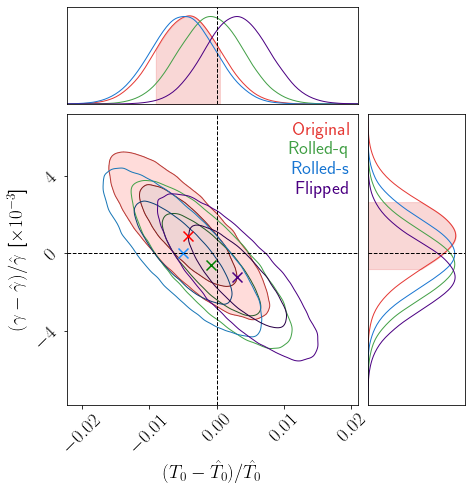

In [161]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()


c.add_chain(
    rsansa_flatchain_committee_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Original',
)
c.add_chain(
    rsansa_flatchain_committee_rolled128_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-q',
)
c.add_chain(
    rsansa_flatchain_committee_rolled_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-s',
)
c.add_chain(
    rsansa_flatchain_committee_flipped_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Flipped',
)


# c.add_chain(
#     rsansa_flatchain_committee_fid_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Original',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled128_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )
# c.add_chain(
#     rsansa_flatchain_committee_flipped_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    bar_shade   = [True, False, False, False, True],
    shade_alpha = [0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'r', marker = 'x', label = "Original mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled128_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'g', marker = 'x', label = "Rolled-q mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_flipped_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'indigo', marker = 'x', label = "Flipped mean", #zorder = 0, 
)
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', markevr = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_tdr_with_rolled_&_flipped_cases.pdf', bbox_inches = 'tight')

T0 =  10104.151919484138
gamma =  1.575970380306244


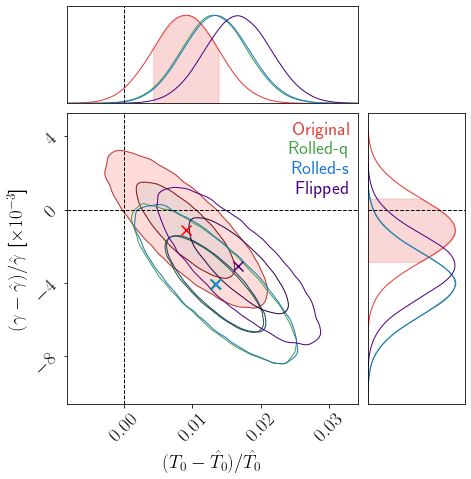

In [195]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()


c.add_chain(
    rsansa_flatchain_committee_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Original',
)
c.add_chain(
    rsansa_flatchain_committee_rolled128_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-q',
)
c.add_chain(
    rsansa_flatchain_committee_rolled_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-s',
)
c.add_chain(
    rsansa_flatchain_committee_flipped_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Flipped',
)


# c.add_chain(
#     rsansa_flatchain_committee_fid_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Original',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled128_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )
# c.add_chain(
#     rsansa_flatchain_committee_flipped_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    bar_shade   = [True, False, False, False, True],
    shade_alpha = [0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'r', marker = 'x', label = "Original mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled128_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'g', marker = 'x', label = "Rolled-q mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_flipped_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'indigo', marker = 'x', label = "Flipped mean", #zorder = 0, 
)
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', markevr = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_tdr_with_rolled_&_flipped_cases.pdf', bbox_inches = 'tight')

T0 =  10104.151919484138
gamma =  1.575970380306244


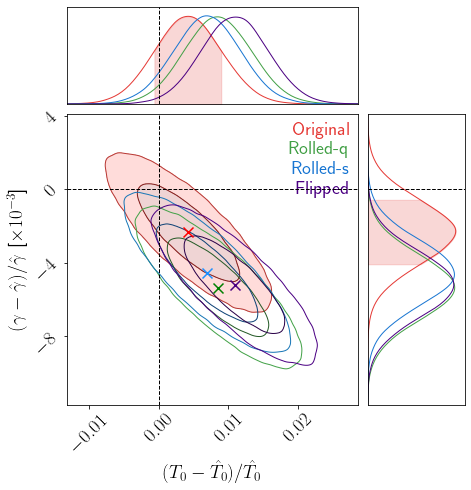

In [231]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0_fid_upscaled)
print('gamma = ', gamma_fid_upscaled)

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()


c.add_chain(
    rsansa_flatchain_committee_fid_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Original',
)
c.add_chain(
    rsansa_flatchain_committee_rolled128_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-q',
)
c.add_chain(
    rsansa_flatchain_committee_rolled_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Rolled-s',
)
c.add_chain(
    rsansa_flatchain_committee_flipped_upscaled,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Flipped',
)


# c.add_chain(
#     rsansa_flatchain_committee_fid_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Original',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled128_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-q',
# )
# c.add_chain(
#     rsansa_flatchain_committee_rolled_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Rolled-s',
# )
# c.add_chain(
#     rsansa_flatchain_committee_flipped_upscaled100,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    bar_shade   = [True, False, False, False, True],
    shade_alpha = [0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
ax.scatter(
    *np.mean(rsansa_flatchain_committee_fid_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'r', marker = 'x', label = "Original mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled128_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'g', marker = 'x', label = "Rolled-q mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_rolled_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
)
ax.scatter(
    *np.mean(rsansa_flatchain_committee_flipped_upscaled, axis = 0), 
    # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
    s = 100, color = 'indigo', marker = 'x', label = "Flipped mean", #zorder = 0, 
)
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', markevr = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+'figures/rSansa_posterior_fiducial_tdr_with_rolled_&_flipped_cases.pdf', bbox_inches = 'tight')

### $\chi^2$ values for the different augmentations

In [130]:
def chi2(chain, truth):
    Cov = np.cov(chain.T)
    inv_Cov = np.linalg.inv(Cov)
    # print(Cov.shape)
    c2 = 0
    for i in range(len(chain)):
        c2 += (chain[i] - truth).dot(inv_Cov.dot((chain[i] - truth).T))
    return c2/len(chain) #(chain-truth).dot(Cov.dot((chain-truth).T))

In [227]:
truth = np.array([T0_fid_upscaled, gamma_fid_upscaled])
# truth_downscaled = np.array([T0_fid, gamma_fid])
chi2_rolled    = chi2((rsansa_flatchain_committee_rolled_upscaled100 + 1.)*truth, truth)
chi2_rr        = chi2((rsansa_flatchain_committee_rr_upscaled100 + 1.)*truth, truth)
chi2_rolled128 = chi2((rsansa_flatchain_committee_rolled128_upscaled100 + 1.)*truth, truth)
chi2_flipped   = chi2((rsansa_flatchain_committee_flipped_upscaled100 + 1.)*truth, truth)
chi2_fr        = chi2((rsansa_flatchain_committee_fr_upscaled100 + 1.)*truth, truth)
chi2_fid       = chi2((rsansa_flatchain_committee_fid_upscaled100 + 1.)*truth, truth)

In [228]:
print("Original:\t", chi2_fid)
print("Rolled-r:\t", chi2_rr)
print("Rolled-s:\t", chi2_rolled)
print("Rolled-q:\t", chi2_rolled128)
print("Flipped:\t", chi2_flipped)
print("Flipped-r:\t", chi2_fr)

Original:	 2.0077985651350208
Rolled-r:	 2.2565999033511903
Rolled-s:	 2.352929386391153
Rolled-q:	 2.379509887254617
Flipped:	 2.240131611603566
Flipped-r:	 2.0167430199209533


In [183]:
rsansa_flatchain_committee_rolled_upscaled100.shape

(500000, 2)

## Testing with noisy spectra

### Adding noise

In [117]:
R = (v_h_skewer[1] - v_h_skewer[0])*8e-5 /6.
print(R)

2.8742141114846866


In [118]:
CNR_array  = np.array([5,20,80,100,200,300,500])
sigv_array = 1./CNR_array
sigp_array = np.sqrt(R)*sigv_array
print(sigp_array)

[0.33907015 0.08476754 0.02119188 0.01695351 0.00847675 0.00565117
 0.0033907 ]


In [119]:
Noise_array = [] #list(Noise_array) 
np.random.seed(100)
for i in range(len(CNR_array)):
    Noise_array.append(np.random.normal(0.0, sigp_array[i], fid_test_spectra[:, :512, :].shape))
Noise_array = np.array(Noise_array)
Noise_array.shape

(7, 4000, 512, 1)

In [120]:
def add_noise(spectra, noise):
    noisy_spectra            = np.copy(spectra) 
    noisy_spectra[:,:512,:] += noise
    return noisy_spectra

In [121]:
SNR_id = -1

In [122]:
idx_of_inference_tester = 36
tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
test_spectra_noisy_single  = add_noise(test_spectra[tester_slice_rsansa], Noise_array[SNR_id])
test_spectra_noisy2_single = add_noise(test_spectra[tester_slice_rsansa], Noise_array[SNR_id-1])

In [123]:
fid_test_spectra_noisy  = add_noise(fid_test_spectra, Noise_array[SNR_id])
fid_test_spectra_noisy2 = add_noise(fid_test_spectra, Noise_array[SNR_id-1])

### First noisy case (CNR = 500)

In [124]:
# with tf.device(f'/device:GPU:{GPU_id}'):
# idx_of_inference_tester = 36
test_preds_committee_noisy_single = []
for i in range(N_members_committee):
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    # tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
    # fid_test_preds_committee_noisy.append(rsansa.predict(fid_test_spectra_noisy[:, :512, :]))
    test_preds_committee_noisy_single.append(rsansa.predict(test_spectra_noisy_single[:, :512, :]))
test_preds_committee_noisy_single = np.array(test_preds_committee_noisy_single)
test_preds_committee_noisy_single.shape 

(10, 4000, 5)

In [106]:
fid_test_preds_committee_noisy_transformed = np.zeros((*fid_test_preds_committee_noisy.shape[:2], 2))
for i in range(N_members_committee):
    fid_test_preds_committee_noisy_transformed[i,:,0] = Ws_rsansa[i,0,0]*fid_test_preds_committee_noisy[i,:,0] + Ws_rsansa[i,0,1]*fid_test_preds_committee_noisy[i,:,1] + Ds_rsansa[i,0]
    fid_test_preds_committee_noisy_transformed[i,:,1] = Ws_rsansa[i,0,1]*fid_test_preds_committee_noisy[i,:,0] + Ws_rsansa[i,1,1]*fid_test_preds_committee_noisy[i,:,1] + Ds_rsansa[i,1]
fid_test_preds_committee_noisy_transformed.shape

(10, 4000, 2)

In [125]:
test_preds_committee_noisy_single_transformed = np.zeros((*test_preds_committee_noisy_single.shape[:2], 2))
for i in range(N_members_committee):
    test_preds_committee_noisy_single_transformed[i,:,0] = Ws_rsansa[i,0,0]*test_preds_committee_noisy_single[i,:,0] + Ws_rsansa[i,0,1]*test_preds_committee_noisy_single[i,:,1] + Ds_rsansa[i,0]
    test_preds_committee_noisy_single_transformed[i,:,1] = Ws_rsansa[i,0,1]*test_preds_committee_noisy_single[i,:,0] + Ws_rsansa[i,1,1]*test_preds_committee_noisy_single[i,:,1] + Ds_rsansa[i,1]
test_preds_committee_noisy_single_transformed.shape

(10, 4000, 2)

In [126]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
noisy_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
noisy_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(test_preds_committee_noisy_single[i, subset_sl, 2])
    c2s = np.exp(test_preds_committee_noisy_single[i, subset_sl, 3])
    c3s = test_preds_committee_noisy_single[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    noisy_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    noisy_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
noisy_test_committee_transformed_network_covariance_matrices.shape, noisy_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [127]:
mean_test_pred_committee_noisy_single_transformed = np.average(test_preds_committee_noisy_single_transformed, axis = 0, weights = 1./noisy_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_test_pred_committee_noisy_single_transformed.shape

(4000, 2)

In [128]:
mean_test_pred_committee_noisy_single_transformed_upscaled = rescale_chain(mean_test_pred_committee_noisy_single_transformed, mode = 'up') 
mean_test_pred_committee_noisy_single_transformed_upscaled.shape

(4000, 2)

In [129]:
# Orthogrid36 model, Noisy test case (CNR = 500)

def compute_likelihood_rsansa_committee_noisy(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_test_pred_committee_noisy_single_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_noisy(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa    = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_single_noisy = sampler_rsansa.flatchain[500000:,:]

In [130]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_single_noisy, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_single_noisy - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_single_noisy_upscaled1 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_single_noisy_upscaled1 = rescale_chain(rsansa_flatchain_committee_single_noisy_upscaled1, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_single_noisy_upscaled1[:,0] = rsansa_flatchain_committee_single_noisy_upscaled1[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_single_noisy_upscaled1[:,1] = rsansa_flatchain_committee_single_noisy_upscaled1[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

In [131]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_single_noisy, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_single_noisy - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/10) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_single_noisy_upscaled10 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_single_noisy_upscaled10 = rescale_chain(rsansa_flatchain_committee_single_noisy_upscaled10, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_single_noisy_upscaled10[:,0] = rsansa_flatchain_committee_single_noisy_upscaled10[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_single_noisy_upscaled10[:,1] = rsansa_flatchain_committee_single_noisy_upscaled10[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

### Second noisy case (CNR = 300)

In [112]:
# with tf.device(f'/device:GPU:{GPU_id}'):
fid_test_preds_committee_noisy2 = []
for i in range(N_members_committee):
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    fid_test_preds_committee_noisy2.append(rsansa.predict(fid_test_spectra_noisy2[:, :512, :]))
fid_test_preds_committee_noisy2 = np.array(fid_test_preds_committee_noisy2)
fid_test_preds_committee_noisy2.shape 

(10, 4000, 5)

In [132]:
# with tf.device(f'/device:GPU:{GPU_id}'):
test_preds_committee_noisy2_single = []
for i in range(N_members_committee):
    rsansa.load_weights(weights_path+f'run_{i}/W_at_epoch_{best_epochs[i]}')
    test_preds_committee_noisy2_single.append(rsansa.predict(test_spectra_noisy2_single[:, :512, :]))
test_preds_committee_noisy2_single = np.array(test_preds_committee_noisy2_single)
test_preds_committee_noisy2_single.shape 

(10, 4000, 5)

In [133]:
test_preds_committee_noisy2_single_transformed = np.zeros((*test_preds_committee_noisy2_single.shape[:2], 2))
for i in range(N_members_committee):
    test_preds_committee_noisy2_single_transformed[i,:,0] = Ws_rsansa[i,0,0]*test_preds_committee_noisy2_single[i,:,0] + Ws_rsansa[i,0,1]*test_preds_committee_noisy2_single[i,:,1] + Ds_rsansa[i,0]
    test_preds_committee_noisy2_single_transformed[i,:,1] = Ws_rsansa[i,0,1]*test_preds_committee_noisy2_single[i,:,0] + Ws_rsansa[i,1,1]*test_preds_committee_noisy2_single[i,:,1] + Ds_rsansa[i,1]
test_preds_committee_noisy2_single_transformed.shape

(10, 4000, 2)

In [134]:
# idx_of_inference_tester = 50
# tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]
noisy2_test_committee_transformed_network_covariance_matrices     = np.zeros((N_members_committee,2,2))
noisy2_test_committee_transformed_network_covariance_determinants = np.zeros(N_members_committee)
for i in range(N_members_committee):
    c1s = np.exp(test_preds_committee_noisy2_single[i, subset_sl, 2])
    c2s = np.exp(test_preds_committee_noisy2_single[i, subset_sl, 3])
    c3s = test_preds_committee_noisy2_single[i, subset_sl, 4] 

    Sigma_inverse_matrices_rsansa    = FromCholeskyToPrecision(c1s, c2s, c3s)

    Sigma_inverse_matrix_mean_rsansa = np.mean(Sigma_inverse_matrices_rsansa, axis = 0)
    Sigma_matrix_mean_rsansa         = np.linalg.inv(Sigma_inverse_matrix_mean_rsansa)
    Sigma_matrix_mean_rsansa         = Ws_rsansa[i].dot(Sigma_matrix_mean_rsansa.dot(Ws_rsansa[i].T))
    
    noisy2_test_committee_transformed_network_covariance_matrices[i] = Sigma_matrix_mean_rsansa
    noisy2_test_committee_transformed_network_covariance_determinants[i] = np.linalg.det(Sigma_matrix_mean_rsansa)
noisy2_test_committee_transformed_network_covariance_matrices.shape, noisy2_test_committee_transformed_network_covariance_determinants.shape

((10, 2, 2), (10,))

In [135]:
mean_test_pred_committee_noisy2_single_transformed = np.average(test_preds_committee_noisy2_single_transformed, axis = 0, weights = 1./noisy2_test_committee_transformed_network_covariance_determinants)[:, :2]
mean_test_pred_committee_noisy2_single_transformed.shape

(4000, 2)

In [136]:
mean_test_pred_committee_noisy2_single_transformed_upscaled = rescale_chain(mean_test_pred_committee_noisy2_single_transformed, mode = 'up') 
mean_test_pred_committee_noisy2_single_transformed_upscaled.shape

(4000, 2)

In [137]:
# Fiducial model, Noisy2 test case (CNR = 300)

def compute_likelihood_rsansa_committee_noisy2(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_test_pred_committee_noisy2_single_transformed[subset_sl, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee_noisy2(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0_fid, gamma_fid]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa    = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_single_noisy2 = sampler_rsansa.flatchain[500000:,:]

In [138]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_single_noisy2, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_single_noisy2 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/10) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_single_noisy2_upscaled10 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_single_noisy2_upscaled10 = rescale_chain(rsansa_flatchain_committee_single_noisy2_upscaled10, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_single_noisy2_upscaled10[:,0] = rsansa_flatchain_committee_single_noisy2_upscaled10[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_single_noisy2_upscaled10[:,1] = rsansa_flatchain_committee_single_noisy2_upscaled10[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

In [139]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_single_noisy2, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_single_noisy2 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_single_noisy2_upscaled1 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_single_noisy2_upscaled1 = rescale_chain(rsansa_flatchain_committee_single_noisy2_upscaled1, mode = 'up')
# rsansa_flatchain_best_rolled_upscaled[:,1] = rescale_gamma(rsansa_flatchain_best_fid_upscaled[:,1], mode = 'up')

rsansa_flatchain_committee_single_noisy2_upscaled1[:,0] = rsansa_flatchain_committee_single_noisy2_upscaled1[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_single_noisy2_upscaled1[:,1] = rsansa_flatchain_committee_single_noisy2_upscaled1[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

### Getting the chains for noiseless test case

In [140]:
# Orthogrid36 model test case, committee

idx_of_inference_tester = 36
tester_slice_rsansa = np.s_[idx_of_inference_tester*N_skewers_each_test : (idx_of_inference_tester+1)*N_skewers_each_test]

def compute_likelihood_rsansa_committee(T0, gamma):
    if not Oracle.in_prior_volume(T0, gamma):
        return -np.inf
    else:
        alpha, beta = change_basis(T0, gamma)
        data        = np.mean(mean_test_rsansa_transformed_committee_predictions[tester_slice_rsansa, :2], axis = 0) #np.array([mean_fid_test_pred_best_network_transformed[0], Means_rsansa_interpolation[idx_of_inference_tester, 1]])
        model       = np.array([mean_T0_interpolator_rsansa_committee(alpha, beta)[0,0], mean_gamma_interpolator_rsansa_committee(alpha, beta)[0,0]])
        C_inv       = np.zeros((2,2))
        for i, j in enumerate([0,1,3]):
            C_inv[j//2, j%2] = invcov_interpolators_rsansa_committee[i](alpha, beta)[0,0]
        C_inv[1,0]  = C_inv[0,1]
        # C_inv      *= N_dSansa
        lnL         = log_likelihood_model_dependent_C(data, model, C_inv)
        return lnL 

nwalkers_rsansa, ndim_rsansa = 100, 2
sampler_rsansa   = emcee.EnsembleSampler(nwalkers_rsansa, ndim_rsansa, lambda x:compute_likelihood_rsansa_committee(*x))

np.random.seed(0)
p0_rsansa        = np.random.randn(nwalkers_rsansa, ndim_rsansa)*[0.01,0.01]+[T0s_orthogrid[idx_of_inference_tester], gammas_orthogrid[idx_of_inference_tester]]
# plt.scatter(p0_sansa[:,0], p0_sansa[:,1], s = 4)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1);
result_rsansa             = sampler_rsansa.run_mcmc(p0_rsansa, 10000)
rsansa_flatchain_committee_orthogrid36 = sampler_rsansa.flatchain[500000:,:]

In [141]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_orthogrid36, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_orthogrid36 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/1) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_orthogrid36_upscaled1 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_orthogrid36_upscaled1 = rescale_chain(rsansa_flatchain_committee_orthogrid36_upscaled1, mode = 'up')

rsansa_flatchain_committee_orthogrid36_upscaled1[:,0] = rsansa_flatchain_committee_orthogrid36_upscaled1[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_orthogrid36_upscaled1[:,1] = rsansa_flatchain_committee_orthogrid36_upscaled1[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

In [142]:
means_rsansa_flatchain    = np.mean(rsansa_flatchain_committee_orthogrid36, axis = 0)
rsansa_deltachain         = rsansa_flatchain_committee_orthogrid36 - means_rsansa_flatchain
rsansa_deltachain        *= np.sqrt(N_rSansa/10) #**2 #np.sqrt(N_interp_sansa)
rsansa_flatchain_committee_orthogrid36_upscaled10 = rsansa_deltachain + means_rsansa_flatchain

rsansa_flatchain_committee_orthogrid36_upscaled10 = rescale_chain(rsansa_flatchain_committee_orthogrid36_upscaled10, mode = 'up')

rsansa_flatchain_committee_orthogrid36_upscaled10[:,0] = rsansa_flatchain_committee_orthogrid36_upscaled10[:,0] / T0s_orthogrid_upscaled[idx_of_inference_tester] - 1
rsansa_flatchain_committee_orthogrid36_upscaled10[:,1] = rsansa_flatchain_committee_orthogrid36_upscaled10[:,1] / gammas_orthogrid_upscaled[idx_of_inference_tester] - 1

### Plotting the posterior distributions

T0 =  12462.50659584185
gamma =  1.4645564646685487


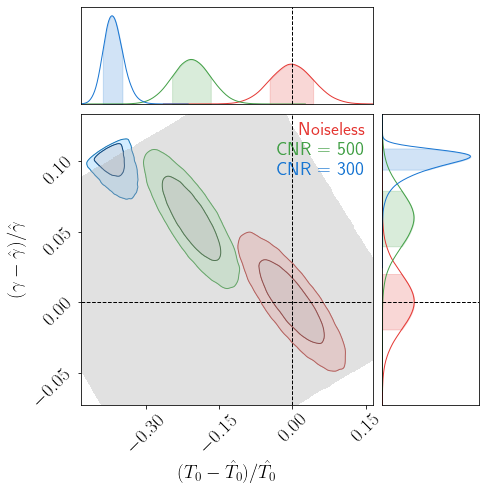

In [204]:
# idx_of_inference_tester = 36
# print('Fiducial')
print('T0 = ', T0s_orthogrid_upscaled[idx_of_inference_tester])
print('gamma = ', gammas_orthogrid_upscaled[idx_of_inference_tester])

# print('\nOffgrid')
# print('T0 = ', T0s_offgrid_upscaled[idx_of_inference_tester_offgrid])
# print('gamma = ', gammas_offgrid_upscaled[idx_of_inference_tester_offgrid])

c   = ChainConsumer()

# c.add_chain(
#     rSansa_posterior_distribution,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'ICV Posterior',
# )

# c.add_chain(
#     mcmc_flatchain_upscaled_ps1d,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = '$P_F(k)$ only',
# )
# # c.add_chain(
# #     mcmc_flatchain_upscaled_fpdf,
# #     parameters = [rel_T0_string, rel_gamma_string],
# #     name = 'FPDF only',
# # )
# c.add_chain(
#     mcmc_flatchain_upscaled_crosscorr,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Joint, $P_F(k)$ \& PDF',
# )
# c.add_chain(
#     mcmc_flatchain_upscaled_nocorr,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = '$P(k)$ \& FPDF, no corr.',
# )


# c.add_chain(
#     rSansa_posterior_distribution_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior',
# )
# c.add_chain(
#     rsansa_flatchain_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Best model',
# )

# c.add_chain(
#     rsansa_flatchain_committee_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Committee',
# )
c.add_chain(
    rsansa_flatchain_committee_orthogrid36_upscaled10,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'Noiseless',
)

# c.add_chain(
#     rSansa_posterior_distribution_rolled_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior, rolled',
# )
c.add_chain(
    rsansa_flatchain_committee_single_noisy_upscaled10,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'CNR = 500',
)
c.add_chain(
    rsansa_flatchain_committee_single_noisy2_upscaled10,
    parameters = [rel_T0_string, rel_gamma_string],
    name = 'CNR = 300',
)

# c.add_chain(
#     rSansa_posterior_distribution_flipped_sc,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Scatter Posterior, flipped',
# )
# c.add_chain(
#     rsansa_flatchain_best_flipped_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Flipped',
# )

# c.add_chain(
#     rsansa_flatchain_offgrid_upscaled,
#     parameters = [rel_T0_string, rel_gamma_string],
#     name = 'Off-grid',
# )


c.configure(
    # kde = 3.0,
    summary = False,
    # sigmas  = [0,1,2,3],
    # linewidths = 0.7,
    tick_font_size = 19,
    label_font_size = 19,
    # bar_shade   = [True, False, False, False, True],
    shade_alpha = 0.2, #[0.2, 0.0, 0.0, 0.0, 0.2], #0.15,
    # shade_gradient = 1.5,
    colors = ['red', 'green', 'blue', '#4B0082', '#054907'], # #
    watermark_text_kwargs = {'alpha':0.2, 'rotation':135}
)

#c.plotter.restore_rc_params()
# plt.rcParams['font.size']       = 16
# plt.rcParams['lines.linewidth'] = 1.7
# plt.rcParams['text.usetex']     = True
fig = c.plotter.plot(
    figsize = (6.5,6.5),
    truth   = [0., 0.],
    # filename = op_path+f'tuner_impl_{impl_id}/figures/rSansa_posterior_fid_rolled_flipped_likelihood-based.pdf', #Arya{impl_id_arya}_Sansa{impl_id_sansa}_{idx_of_inference_tester}.pdf', #
    legend  = True,
    #extents = [(-2.2,2.2),(-1.1, 1.1)],
    # extents = [(-0.2,0.18),(-0.07, 0.09)],
    #watermark = 'Preliminary'
)

ax = fig.axes[2]
alphas = np.ones(Prior_matrix.shape)*0.35
alphas[np.invert(Prior_matrix)] = 0 
ax.pcolormesh(T0s_prior_upscaled/T0s_orthogrid_upscaled[idx_of_inference_tester] - 1, gammas_prior_upscaled/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, Prior_matrix, cmap = 'binary', shading = 'auto', vmin = 0., vmax = 3., alpha = alphas)

# ax.scatter(
#     rel_T0s_orthogrid_upscaled, 
#     rel_gammas_orthogrid_upscaled, 
#     color = 'k', s = 9, zorder = 0
# )
# ax.scatter(
#     rel_T0s_orthogrid_upscaled[60], 
#     rel_gammas_orthogrid_upscaled[60], 
#     color = 'g', s = 16, zorder = 0
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_fid_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'r', marker = 'x', label = "Original mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_rolled128_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'g', marker = 'x', label = "Rolled-q mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_rolled_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'dodgerblue', marker = 'x', label = "Rolled-s mean", #zorder = 0, 
# )
# ax.scatter(
#     *np.mean(rsansa_flatchain_best_flipped_upscaled, axis = 0), 
#     # rescale_gamma(Means_rsansa_interpolation[idx_of_inference_tester,1], mode = 'up')/gammas_orthogrid_upscaled[idx_of_inference_tester] - 1, 
#     s = 100, color = 'indigo', marker = 'x', label = "Flipped mean", #zorder = 0, 
# )
# ax.scatter(
#     rescale_T0(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,0], mode = 'up')/T0s_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     rescale_gamma(mean_preds_rsansa_offgrid[idx_of_inference_tester_offgrid,1], mode = 'up')/gammas_offgrid_upscaled[idx_of_inference_tester_offgrid] - 1, 
#     s = 100, color = 'darkgreen', marker = 'x', label = "Off-grid mean", #zorder = 0, 
# )
# ax.legend(fontsize = 15)
c.plotter.restore_rc_params()
# plt.savefig(op_path+f'figures/rSansa_posterior_orthogrid{idx_of_inference_tester}_with_noisy_cases_10LOS.pdf', bbox_inches = 'tight', dpi = 300)

In [166]:
detC_noisy   = np.linalg.det(np.cov(rsansa_flatchain_committee_single_noisy_upscaled10.T))
# detC_nocorr = np.linalg.det(np.cov(mcmc_flatchain_upscaled_nocorr.T))
detC_noisy2  = np.linalg.det(np.cov(rsansa_flatchain_committee_single_noisy2_upscaled10.T))
# detC_rsansa      = np.linalg.det(np.cov(rsansa_flatchain_best_fid_upscaled100.T))
detC_rsansa_committee_noiseless = np.linalg.det(np.cov(rsansa_flatchain_committee_orthogrid36_upscaled10.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_flatchain_upscaled.T))
# detC_rsansa = np.linalg.det(np.cov(rsansa_preds.T)/100)
# print(detC_ps1d)
# print(detC_corr)
# print(detC_rsansa_best)
# print(detC_ps1d/detC_rsansa)
# print(detC_corr/detC_rsansa)

print(np.sqrt(detC_noisy/detC_rsansa_committee_noiseless))
print(np.sqrt(detC_noisy2/detC_rsansa_committee_noiseless))
print(np.sqrt(detC_noisy/detC_noisy2))

0.9154180886431038
0.3579115931780094
2.557665373492988


In [130]:
def chi2(chain, truth):
    Cov = np.cov(chain.T)
    inv_Cov = np.linalg.inv(Cov)
    # print(Cov.shape)
    c2 = 0
    for i in range(len(chain)):
        c2 += (chain[i] - truth).dot(inv_Cov.dot((chain[i] - truth).T))
    return c2/len(chain) #(chain-truth).dot(Cov.dot((chain-truth).T))

In [159]:
truth = np.array([T0s_orthogrid_upscaled[idx_of_inference_tester], gammas_orthogrid_upscaled[idx_of_inference_tester]])
chi2_noisy     = chi2((rsansa_flatchain_committee_single_noisy_upscaled10 + 1.)*truth, truth)
chi2_noisy2    = chi2((rsansa_flatchain_committee_single_noisy2_upscaled10 + 1.)*truth, truth)
chi2_noiseless = chi2((rsansa_flatchain_committee_orthogrid36_upscaled10 + 1.)*truth, truth)

In [160]:
print("Noiseless:\t", chi2_noiseless)
print("CNR500:\t", chi2_noisy)
print("CNR300:\t", chi2_noisy2)

Noiseless:	 2.000776192403765
CNR500:	 35.33906855619204
CNR300:	 1220.702955293081
